In [61]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import swifter

from ast import literal_eval
from dateutil.relativedelta import relativedelta
from scipy.stats import kurtosis, skew
from shapely.geometry import Point
from shapely.wkt import loads
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [2]:
crs = 'epsg:6372'
file_path = "../data/interim/00mun_with_neighbours.csv"
data = pd.read_csv(file_path, index_col=0)
data.geometry = data.geometry.apply(loads)
data = gpd.GeoDataFrame(data, crs=crs)
data['CVE_CONCAT'] = data.CVE_CONCAT.apply(
    lambda x: str(x).zfill(5)
)

In [3]:
drought_file = '../data/raw/raw_data.h5'
drought_data = pd.read_hdf(drought_file, key='raw_core')
drought_data['CVE_CONCATENADA'] = drought_data.CVE_CONCATENADA.apply(
    lambda x: str(x).zfill(5)
)

In [4]:
columns = drought_data.columns 
dates = [col for col in columns if not isinstance(col, str)]
columns_no_dates = list(set(columns)-set(dates))

drought_melted_data = pd.melt(
    drought_data, 
    id_vars=['CVE_CONCATENADA'],
    value_vars=dates, 
    ignore_index=True,
    var_name='date', 
    value_name='drought_level'
)


In [5]:
def get_coeficient(level):
    if isinstance(level, str):
        return int(level.replace('D',''))
    
drought_melted_data['drought_level_coef'] = drought_melted_data.drought_level.apply(get_coeficient)

In [6]:
def get_features(cve_concat):
    feature_dict = {
        'feature1':'mean_drought_level_coef_neighbours1',
        'feature2':'mean_drought_level_coef_neighbours2',
        'feature3':'gradient_mean_drought_level_neighbours',
    }
    neighbours_1 = literal_eval(data[data.CVE_CONCAT==cve_concat].cve_concat_list_of_neighbour_municipalities.values[0])
    neighbours_2 = literal_eval(data[data.CVE_CONCAT==cve_concat].cve_concat_list_of_2nd_neighbour_municipalities.values[0])
    ax = drought_melted_data[drought_melted_data.CVE_CONCATENADA.isin(neighbours_1)].dropna().groupby('date').mean().rename(
        columns={'drought_level_coef':feature_dict['feature1']}
    )

    ax2 = drought_melted_data[drought_melted_data.CVE_CONCATENADA.isin(neighbours_2)].dropna().groupby('date').mean().rename(
        columns={'drought_level_coef':feature_dict['feature2']}
    )
    space_grad = (ax[feature_dict['feature1']]-ax2[feature_dict['feature2']])
    features = pd.concat([ax,ax2],axis=1)
    features[feature_dict['feature3']] = space_grad
    features['CVE_CONCAT'] = cve_concat
    return features

In [7]:
data['features_df'] = data.CVE_CONCAT.swifter.apply(get_features)

Pandas Apply:   0%|          | 0/2469 [00:00<?, ?it/s]

In [8]:
features_dataframe = pd.concat(
    data['features_df'].to_list()
).reset_index().set_index(['CVE_CONCAT', 'date'])

In [9]:
drought_melted_data_ordered = drought_melted_data.sort_values(
    ['CVE_CONCATENADA', 'date']).rename(
    columns={'CVE_CONCATENADA':'CVE_CONCAT'}).set_index(
    ['CVE_CONCAT', 'date']
)

In [10]:
drought_melted_data_ordered_features = pd.concat(
    [drought_melted_data_ordered, features_dataframe],
    axis=1
)

In [11]:
drought_melted_data = drought_melted_data_ordered_features[
    drought_melted_data_ordered_features.drought_level.notna()
].reset_index()

In [12]:
def calculate_next_date(date):
    day = date.day
    if day == 15:
        next_date = date + pd.DateOffset(months=1)
    else:
        next_date = (date + pd.DateOffset(days=5)) +relativedelta(day=31)
    return next_date
    
drought_melted_data['future_date'] = drought_melted_data.date.apply(calculate_next_date)

In [13]:
drought_melted_data['unique_index_cve_date'] = (
    drought_melted_data['CVE_CONCAT'] +
    '_' + 
    drought_melted_data['date'].astype(str))

drought_melted_data['future_unique_index_cve_date'] = (
    drought_melted_data['CVE_CONCAT'] +
    '_' + 
    drought_melted_data['future_date'].astype(str))

indexed_val = drought_melted_data[['unique_index_cve_date', 'drought_level_coef']]
future_info = indexed_val[indexed_val.unique_index_cve_date.isin(
    drought_melted_data['future_unique_index_cve_date'])].rename(
    columns={
        'unique_index_cve_date':'future_unique_index_cve_date',
        'drought_level_coef': 'next_month_drought_level_coef',
    }
)
drought_melted_data_with_target = drought_melted_data.merge(future_info, on='future_unique_index_cve_date', how='inner')

In [14]:
def get_weights(df):
    df = df.sort_values('future_date')
    gradient_over_time = np.gradient(df.next_month_drought_level_coef)
    df['grad'] = gradient_over_time
    return df[['CVE_CONCAT','future_date', 'grad']]
    
weights = drought_melted_data_with_target.groupby('CVE_CONCAT').apply(get_weights)

In [15]:
weights['weights'] = (weights.grad - weights.grad.min() + 1)/ weights.grad.max()
weights['future_unique_index_cve_date'] = (
    weights['CVE_CONCAT'] +
    '_' + 
    weights['future_date'].astype(str))

In [16]:
drought_melted_data_with_target_and_weights = drought_melted_data_with_target.merge(weights[
    ['grad', 'future_unique_index_cve_date']
], on='future_unique_index_cve_date')

In [19]:
def get_rolling_features(df, days=120):
    time_txt = f'_last{days}_days'
    df_to_concat = df[['CVE_CONCAT', 'unique_index_cve_date']]
    rolling_df = df.rolling(f'{days}D', min_periods=days//30, on='date')
    mean_roll = rolling_df.mean().drop('date', axis=1)
    cols = mean_roll.columns
    mean_roll.rename(columns={col:col + '_mean' + time_txt for col in cols}, inplace=True)
    std_roll = rolling_df.std().drop('date', axis=1).rename(
        columns={col:col+'_std' + time_txt for col in cols}
    )
    grd_roll = rolling_df.apply(lambda x: np.mean(np.gradient(x))).drop('date', axis=1).rename(
        columns={col:col+'_grad' + time_txt for col in cols}
    )
    grd_std_roll = rolling_df.apply(lambda x: np.std(np.gradient(x))).drop('date', axis=1).rename(
        columns={col:col+'_grad_std' + time_txt for col in cols}
    )
    kurtosis_roll = rolling_df.apply(kurtosis).drop('date', axis=1).rename(
        columns={col:col+'_kurtosis' + time_txt for col in cols}
    )
    skewness_roll = rolling_df.apply(skew).drop('date', axis=1).rename(
        columns={col:col+'_skewness' + time_txt for col in cols}
    )
    df_list = [
        df_to_concat,
        mean_roll,
        std_roll,
        grd_roll,
        grd_std_roll,
        kurtosis_roll,
        skewness_roll,
    ]
    all_rolling_data = pd.concat(df_list, axis=1)
    return all_rolling_data

In [76]:
rolling_features60 = drought_melted_data.groupby('CVE_CONCAT').apply(get_rolling_features, days=60)
rolling_features90 = drought_melted_data.groupby('CVE_CONCAT').apply(get_rolling_features, days=90)
rolling_features120 = drought_melted_data.groupby('CVE_CONCAT').apply(get_rolling_features, days=120)
rolling_features150 = drought_melted_data.groupby('CVE_CONCAT').apply(get_rolling_features, days=150)
rolling_features180 = drought_melted_data.groupby('CVE_CONCAT').apply(get_rolling_features, days=180)
rolling_features210 = drought_melted_data.groupby('CVE_CONCAT').apply(get_rolling_features, days=210)
rolling_features240 = drought_melted_data.groupby('CVE_CONCAT').apply(get_rolling_features, days=240)
rolling_features270 = drought_melted_data.groupby('CVE_CONCAT').apply(get_rolling_features, days=270)
rolling_features300 = drought_melted_data.groupby('CVE_CONCAT').apply(get_rolling_features, days=300)
rolling_features330 = drought_melted_data.groupby('CVE_CONCAT').apply(get_rolling_features, days=330)
rolling_features360 = drought_melted_data.groupby('CVE_CONCAT').apply(get_rolling_features, days=360)

In [77]:
rolling_features_list = [
    rolling_features60.drop('CVE_CONCAT', axis=1),
    rolling_features90.drop(['CVE_CONCAT', 'unique_index_cve_date'], axis=1),
    rolling_features120.drop(['CVE_CONCAT', 'unique_index_cve_date'], axis=1),
    rolling_features150.drop(['CVE_CONCAT', 'unique_index_cve_date'], axis=1),
    rolling_features180.drop(['CVE_CONCAT', 'unique_index_cve_date'], axis=1),
    rolling_features210.drop(['CVE_CONCAT', 'unique_index_cve_date'], axis=1),
    rolling_features240.drop(['CVE_CONCAT', 'unique_index_cve_date'], axis=1),
    rolling_features270.drop(['CVE_CONCAT', 'unique_index_cve_date'], axis=1),
    rolling_features300.drop(['CVE_CONCAT', 'unique_index_cve_date'], axis=1),
    rolling_features330.drop(['CVE_CONCAT', 'unique_index_cve_date'], axis=1),
    rolling_features360.drop(['CVE_CONCAT', 'unique_index_cve_date'], axis=1),
]
rolling_features = pd.concat(rolling_features_list, axis=1)

In [78]:
drought_melted_data_with_target_and_weights_and_features = drought_melted_data_with_target_and_weights.merge(
    rolling_features, on='unique_index_cve_date', how='left')

In [114]:
drought_melted_data_with_target_and_weights_and_features.to_csv('../data/processed/drought_melted_data_with_target_and_weights_and_features.csv')

In [79]:
feature_columns = [
    'mean_drought_level_coef_neighbours1',
    'mean_drought_level_coef_neighbours2',
    'gradient_mean_drought_level_neighbours',
] + [col for col in rolling_features.drop('unique_index_cve_date',axis=1)]
target = 'next_month_drought_level_coef'
weight = 'grad'

In [80]:
start_train, end_train = pd.to_datetime('2010-01-01'), pd.to_datetime('2020-01-01')
start_oot, end_oot = pd.to_datetime('2020-01-01'), pd.to_datetime('2023-01-01')

window_train = drought_melted_data_with_target_and_weights_and_features.date.between(start_train, end_train)
window_oot = drought_melted_data_with_target_and_weights_and_features.date.between(start_oot, end_oot)

In [81]:
data_train = drought_melted_data_with_target_and_weights_and_features[window_train]
data_train_with_weight = data_train[data_train[weight] != 0]
x_train, y_train = data_train_with_weight[feature_columns], data_train_with_weight[target] >= 2

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.20, random_state=42)
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

data_oot = drought_melted_data_with_target_and_weights_and_features[window_oot]
data_oot_with_weight = data_oot[data_oot[weight] != 0]

x_oot, y_oot = data_oot_with_weight[feature_columns], data_oot_with_weight[target] >= 2

w_train = np.exp(data_train_with_weight.loc[x_train.index][weight])
w_test = np.exp(data_train_with_weight.loc[x_test.index][weight])
w_dev = np.exp(data_train_with_weight.loc[x_dev.index][weight])
w_oot = np.exp(data_oot_with_weight.loc[x_oot.index][weight])

In [82]:
model = XGBClassifier(
    n_estimators=100000,
    max_depth=5,
    max_leaves=0,
    learning_rate=0.01,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.7,
    colsample_bylevel=0.7,
    colsample_bynode=0.7,
    random_state=42,
)

In [83]:
model.fit(
    x_train, y_train, 
    sample_weight=abs(w_train),
    eval_set=[(x_train, y_train), (x_test, y_test), (x_dev, y_dev)],
    sample_weight_eval_set = [abs(w_train), abs(w_test), abs(w_dev)],
    eval_metric=['aucpr', 'auc'],
    early_stopping_rounds=100,
)

[0]	validation_0-aucpr:0.70682	validation_0-auc:0.82663	validation_1-aucpr:0.68718	validation_1-auc:0.80868	validation_2-aucpr:0.66943	validation_2-auc:0.80187
[1]	validation_0-aucpr:0.74755	validation_0-auc:0.85189	validation_1-aucpr:0.72667	validation_1-auc:0.83649	validation_2-aucpr:0.71891	validation_2-auc:0.82757
[2]	validation_0-aucpr:0.75988	validation_0-auc:0.86077	validation_1-aucpr:0.74157	validation_1-auc:0.84566	validation_2-aucpr:0.72961	validation_2-auc:0.83686
[3]	validation_0-aucpr:0.76485	validation_0-auc:0.86232	validation_1-aucpr:0.74711	validation_1-auc:0.84669	validation_2-aucpr:0.73670	validation_2-auc:0.84061
[4]	validation_0-aucpr:0.76545	validation_0-auc:0.86248	validation_1-aucpr:0.74719	validation_1-auc:0.84707	validation_2-aucpr:0.73798	validation_2-auc:0.84149
[5]	validation_0-aucpr:0.76560	validation_0-auc:0.86286	validation_1-aucpr:0.74443	validation_1-auc:0.84492	validation_2-aucpr:0.73735	validation_2-auc:0.84194
[6]	validation_0-aucpr:0.76473	validatio

[51]	validation_0-aucpr:0.78021	validation_0-auc:0.87413	validation_1-aucpr:0.75808	validation_1-auc:0.85655	validation_2-aucpr:0.74697	validation_2-auc:0.84860
[52]	validation_0-aucpr:0.78037	validation_0-auc:0.87425	validation_1-aucpr:0.75800	validation_1-auc:0.85643	validation_2-aucpr:0.74723	validation_2-auc:0.84892
[53]	validation_0-aucpr:0.78069	validation_0-auc:0.87460	validation_1-aucpr:0.75811	validation_1-auc:0.85646	validation_2-aucpr:0.74744	validation_2-auc:0.84901
[54]	validation_0-aucpr:0.78081	validation_0-auc:0.87476	validation_1-aucpr:0.75826	validation_1-auc:0.85664	validation_2-aucpr:0.74744	validation_2-auc:0.84906
[55]	validation_0-aucpr:0.78091	validation_0-auc:0.87476	validation_1-aucpr:0.75816	validation_1-auc:0.85659	validation_2-aucpr:0.74742	validation_2-auc:0.84895
[56]	validation_0-aucpr:0.78107	validation_0-auc:0.87483	validation_1-aucpr:0.75830	validation_1-auc:0.85666	validation_2-aucpr:0.74746	validation_2-auc:0.84883
[57]	validation_0-aucpr:0.78122	va

[102]	validation_0-aucpr:0.78895	validation_0-auc:0.88034	validation_1-aucpr:0.76406	validation_1-auc:0.86080	validation_2-aucpr:0.75443	validation_2-auc:0.85322
[103]	validation_0-aucpr:0.78907	validation_0-auc:0.88033	validation_1-aucpr:0.76416	validation_1-auc:0.86077	validation_2-aucpr:0.75446	validation_2-auc:0.85321
[104]	validation_0-aucpr:0.78921	validation_0-auc:0.88045	validation_1-aucpr:0.76431	validation_1-auc:0.86095	validation_2-aucpr:0.75446	validation_2-auc:0.85321
[105]	validation_0-aucpr:0.78934	validation_0-auc:0.88047	validation_1-aucpr:0.76426	validation_1-auc:0.86090	validation_2-aucpr:0.75462	validation_2-auc:0.85330
[106]	validation_0-aucpr:0.78936	validation_0-auc:0.88050	validation_1-aucpr:0.76428	validation_1-auc:0.86088	validation_2-aucpr:0.75459	validation_2-auc:0.85329
[107]	validation_0-aucpr:0.78955	validation_0-auc:0.88061	validation_1-aucpr:0.76441	validation_1-auc:0.86101	validation_2-aucpr:0.75477	validation_2-auc:0.85336
[108]	validation_0-aucpr:0.7

[153]	validation_0-aucpr:0.79688	validation_0-auc:0.88509	validation_1-aucpr:0.76943	validation_1-auc:0.86406	validation_2-aucpr:0.76016	validation_2-auc:0.85602
[154]	validation_0-aucpr:0.79699	validation_0-auc:0.88517	validation_1-aucpr:0.76955	validation_1-auc:0.86412	validation_2-aucpr:0.76036	validation_2-auc:0.85622
[155]	validation_0-aucpr:0.79716	validation_0-auc:0.88529	validation_1-aucpr:0.76967	validation_1-auc:0.86419	validation_2-aucpr:0.76055	validation_2-auc:0.85640
[156]	validation_0-aucpr:0.79728	validation_0-auc:0.88536	validation_1-aucpr:0.76974	validation_1-auc:0.86428	validation_2-aucpr:0.76079	validation_2-auc:0.85674
[157]	validation_0-aucpr:0.79738	validation_0-auc:0.88536	validation_1-aucpr:0.76992	validation_1-auc:0.86432	validation_2-aucpr:0.76093	validation_2-auc:0.85676
[158]	validation_0-aucpr:0.79761	validation_0-auc:0.88552	validation_1-aucpr:0.77005	validation_1-auc:0.86442	validation_2-aucpr:0.76116	validation_2-auc:0.85692
[159]	validation_0-aucpr:0.7

[204]	validation_0-aucpr:0.80492	validation_0-auc:0.89071	validation_1-aucpr:0.77449	validation_1-auc:0.86729	validation_2-aucpr:0.76704	validation_2-auc:0.86136
[205]	validation_0-aucpr:0.80509	validation_0-auc:0.89080	validation_1-aucpr:0.77461	validation_1-auc:0.86736	validation_2-aucpr:0.76713	validation_2-auc:0.86139
[206]	validation_0-aucpr:0.80523	validation_0-auc:0.89088	validation_1-aucpr:0.77462	validation_1-auc:0.86734	validation_2-aucpr:0.76722	validation_2-auc:0.86141
[207]	validation_0-aucpr:0.80549	validation_0-auc:0.89111	validation_1-aucpr:0.77473	validation_1-auc:0.86745	validation_2-aucpr:0.76747	validation_2-auc:0.86170
[208]	validation_0-aucpr:0.80564	validation_0-auc:0.89127	validation_1-aucpr:0.77484	validation_1-auc:0.86748	validation_2-aucpr:0.76756	validation_2-auc:0.86177
[209]	validation_0-aucpr:0.80573	validation_0-auc:0.89134	validation_1-aucpr:0.77492	validation_1-auc:0.86762	validation_2-aucpr:0.76753	validation_2-auc:0.86179
[210]	validation_0-aucpr:0.8

[255]	validation_0-aucpr:0.81297	validation_0-auc:0.89691	validation_1-aucpr:0.77883	validation_1-auc:0.87057	validation_2-aucpr:0.77191	validation_2-auc:0.86553
[256]	validation_0-aucpr:0.81307	validation_0-auc:0.89699	validation_1-aucpr:0.77883	validation_1-auc:0.87058	validation_2-aucpr:0.77191	validation_2-auc:0.86549
[257]	validation_0-aucpr:0.81323	validation_0-auc:0.89720	validation_1-aucpr:0.77885	validation_1-auc:0.87065	validation_2-aucpr:0.77198	validation_2-auc:0.86560
[258]	validation_0-aucpr:0.81336	validation_0-auc:0.89732	validation_1-aucpr:0.77893	validation_1-auc:0.87076	validation_2-aucpr:0.77207	validation_2-auc:0.86570
[259]	validation_0-aucpr:0.81350	validation_0-auc:0.89748	validation_1-aucpr:0.77906	validation_1-auc:0.87091	validation_2-aucpr:0.77204	validation_2-auc:0.86577
[260]	validation_0-aucpr:0.81366	validation_0-auc:0.89759	validation_1-aucpr:0.77917	validation_1-auc:0.87099	validation_2-aucpr:0.77213	validation_2-auc:0.86587
[261]	validation_0-aucpr:0.8

[306]	validation_0-aucpr:0.82096	validation_0-auc:0.90289	validation_1-aucpr:0.78304	validation_1-auc:0.87425	validation_2-aucpr:0.77662	validation_2-auc:0.86994
[307]	validation_0-aucpr:0.82115	validation_0-auc:0.90299	validation_1-aucpr:0.78318	validation_1-auc:0.87431	validation_2-aucpr:0.77674	validation_2-auc:0.87000
[308]	validation_0-aucpr:0.82129	validation_0-auc:0.90308	validation_1-aucpr:0.78321	validation_1-auc:0.87433	validation_2-aucpr:0.77670	validation_2-auc:0.86995
[309]	validation_0-aucpr:0.82140	validation_0-auc:0.90314	validation_1-aucpr:0.78327	validation_1-auc:0.87439	validation_2-aucpr:0.77668	validation_2-auc:0.86995
[310]	validation_0-aucpr:0.82154	validation_0-auc:0.90322	validation_1-aucpr:0.78336	validation_1-auc:0.87441	validation_2-aucpr:0.77674	validation_2-auc:0.87003
[311]	validation_0-aucpr:0.82162	validation_0-auc:0.90330	validation_1-aucpr:0.78339	validation_1-auc:0.87445	validation_2-aucpr:0.77679	validation_2-auc:0.87010
[312]	validation_0-aucpr:0.8

[357]	validation_0-aucpr:0.82816	validation_0-auc:0.90820	validation_1-aucpr:0.78717	validation_1-auc:0.87761	validation_2-aucpr:0.78074	validation_2-auc:0.87378
[358]	validation_0-aucpr:0.82832	validation_0-auc:0.90829	validation_1-aucpr:0.78728	validation_1-auc:0.87767	validation_2-aucpr:0.78085	validation_2-auc:0.87386
[359]	validation_0-aucpr:0.82854	validation_0-auc:0.90842	validation_1-aucpr:0.78739	validation_1-auc:0.87770	validation_2-aucpr:0.78109	validation_2-auc:0.87409
[360]	validation_0-aucpr:0.82878	validation_0-auc:0.90856	validation_1-aucpr:0.78753	validation_1-auc:0.87780	validation_2-aucpr:0.78129	validation_2-auc:0.87420
[361]	validation_0-aucpr:0.82892	validation_0-auc:0.90865	validation_1-aucpr:0.78759	validation_1-auc:0.87786	validation_2-aucpr:0.78133	validation_2-auc:0.87421
[362]	validation_0-aucpr:0.82908	validation_0-auc:0.90876	validation_1-aucpr:0.78763	validation_1-auc:0.87791	validation_2-aucpr:0.78138	validation_2-auc:0.87421
[363]	validation_0-aucpr:0.8

[408]	validation_0-aucpr:0.83547	validation_0-auc:0.91351	validation_1-aucpr:0.79087	validation_1-auc:0.88059	validation_2-aucpr:0.78516	validation_2-auc:0.87748
[409]	validation_0-aucpr:0.83563	validation_0-auc:0.91360	validation_1-aucpr:0.79097	validation_1-auc:0.88071	validation_2-aucpr:0.78527	validation_2-auc:0.87752
[410]	validation_0-aucpr:0.83574	validation_0-auc:0.91370	validation_1-aucpr:0.79109	validation_1-auc:0.88088	validation_2-aucpr:0.78530	validation_2-auc:0.87756
[411]	validation_0-aucpr:0.83585	validation_0-auc:0.91375	validation_1-aucpr:0.79119	validation_1-auc:0.88094	validation_2-aucpr:0.78542	validation_2-auc:0.87764
[412]	validation_0-aucpr:0.83607	validation_0-auc:0.91389	validation_1-aucpr:0.79131	validation_1-auc:0.88099	validation_2-aucpr:0.78552	validation_2-auc:0.87773
[413]	validation_0-aucpr:0.83615	validation_0-auc:0.91396	validation_1-aucpr:0.79145	validation_1-auc:0.88112	validation_2-aucpr:0.78562	validation_2-auc:0.87782
[414]	validation_0-aucpr:0.8

[459]	validation_0-aucpr:0.84121	validation_0-auc:0.91741	validation_1-aucpr:0.79430	validation_1-auc:0.88386	validation_2-aucpr:0.78841	validation_2-auc:0.87989
[460]	validation_0-aucpr:0.84129	validation_0-auc:0.91750	validation_1-aucpr:0.79438	validation_1-auc:0.88397	validation_2-aucpr:0.78843	validation_2-auc:0.87995
[461]	validation_0-aucpr:0.84144	validation_0-auc:0.91761	validation_1-aucpr:0.79442	validation_1-auc:0.88400	validation_2-aucpr:0.78849	validation_2-auc:0.88002
[462]	validation_0-aucpr:0.84162	validation_0-auc:0.91777	validation_1-aucpr:0.79453	validation_1-auc:0.88409	validation_2-aucpr:0.78857	validation_2-auc:0.88009
[463]	validation_0-aucpr:0.84174	validation_0-auc:0.91784	validation_1-aucpr:0.79455	validation_1-auc:0.88407	validation_2-aucpr:0.78862	validation_2-auc:0.88011
[464]	validation_0-aucpr:0.84188	validation_0-auc:0.91798	validation_1-aucpr:0.79463	validation_1-auc:0.88417	validation_2-aucpr:0.78870	validation_2-auc:0.88020
[465]	validation_0-aucpr:0.8

[510]	validation_0-aucpr:0.84722	validation_0-auc:0.92173	validation_1-aucpr:0.79712	validation_1-auc:0.88622	validation_2-aucpr:0.79132	validation_2-auc:0.88235
[511]	validation_0-aucpr:0.84736	validation_0-auc:0.92183	validation_1-aucpr:0.79709	validation_1-auc:0.88616	validation_2-aucpr:0.79135	validation_2-auc:0.88236
[512]	validation_0-aucpr:0.84748	validation_0-auc:0.92189	validation_1-aucpr:0.79716	validation_1-auc:0.88621	validation_2-aucpr:0.79142	validation_2-auc:0.88242
[513]	validation_0-aucpr:0.84765	validation_0-auc:0.92205	validation_1-aucpr:0.79720	validation_1-auc:0.88624	validation_2-aucpr:0.79149	validation_2-auc:0.88252
[514]	validation_0-aucpr:0.84778	validation_0-auc:0.92214	validation_1-aucpr:0.79726	validation_1-auc:0.88629	validation_2-aucpr:0.79155	validation_2-auc:0.88254
[515]	validation_0-aucpr:0.84786	validation_0-auc:0.92218	validation_1-aucpr:0.79729	validation_1-auc:0.88629	validation_2-aucpr:0.79160	validation_2-auc:0.88259
[516]	validation_0-aucpr:0.8

[561]	validation_0-aucpr:0.85250	validation_0-auc:0.92531	validation_1-aucpr:0.79973	validation_1-auc:0.88825	validation_2-aucpr:0.79396	validation_2-auc:0.88432
[562]	validation_0-aucpr:0.85260	validation_0-auc:0.92536	validation_1-aucpr:0.79983	validation_1-auc:0.88831	validation_2-aucpr:0.79399	validation_2-auc:0.88433
[563]	validation_0-aucpr:0.85269	validation_0-auc:0.92540	validation_1-aucpr:0.79990	validation_1-auc:0.88833	validation_2-aucpr:0.79408	validation_2-auc:0.88438
[564]	validation_0-aucpr:0.85281	validation_0-auc:0.92548	validation_1-aucpr:0.79997	validation_1-auc:0.88839	validation_2-aucpr:0.79414	validation_2-auc:0.88440
[565]	validation_0-aucpr:0.85297	validation_0-auc:0.92558	validation_1-aucpr:0.80008	validation_1-auc:0.88851	validation_2-aucpr:0.79424	validation_2-auc:0.88450
[566]	validation_0-aucpr:0.85309	validation_0-auc:0.92567	validation_1-aucpr:0.80009	validation_1-auc:0.88851	validation_2-aucpr:0.79424	validation_2-auc:0.88452
[567]	validation_0-aucpr:0.8

[612]	validation_0-aucpr:0.85768	validation_0-auc:0.92860	validation_1-aucpr:0.80232	validation_1-auc:0.89006	validation_2-aucpr:0.79641	validation_2-auc:0.88612
[613]	validation_0-aucpr:0.85773	validation_0-auc:0.92863	validation_1-aucpr:0.80232	validation_1-auc:0.89008	validation_2-aucpr:0.79644	validation_2-auc:0.88615
[614]	validation_0-aucpr:0.85789	validation_0-auc:0.92872	validation_1-aucpr:0.80238	validation_1-auc:0.89011	validation_2-aucpr:0.79656	validation_2-auc:0.88622
[615]	validation_0-aucpr:0.85795	validation_0-auc:0.92875	validation_1-aucpr:0.80240	validation_1-auc:0.89013	validation_2-aucpr:0.79655	validation_2-auc:0.88621
[616]	validation_0-aucpr:0.85804	validation_0-auc:0.92881	validation_1-aucpr:0.80244	validation_1-auc:0.89016	validation_2-aucpr:0.79659	validation_2-auc:0.88625
[617]	validation_0-aucpr:0.85811	validation_0-auc:0.92889	validation_1-aucpr:0.80250	validation_1-auc:0.89026	validation_2-aucpr:0.79668	validation_2-auc:0.88640
[618]	validation_0-aucpr:0.8

[663]	validation_0-aucpr:0.86251	validation_0-auc:0.93166	validation_1-aucpr:0.80449	validation_1-auc:0.89167	validation_2-aucpr:0.79897	validation_2-auc:0.88801
[664]	validation_0-aucpr:0.86256	validation_0-auc:0.93167	validation_1-aucpr:0.80451	validation_1-auc:0.89167	validation_2-aucpr:0.79893	validation_2-auc:0.88799
[665]	validation_0-aucpr:0.86266	validation_0-auc:0.93175	validation_1-aucpr:0.80457	validation_1-auc:0.89172	validation_2-aucpr:0.79897	validation_2-auc:0.88802
[666]	validation_0-aucpr:0.86277	validation_0-auc:0.93181	validation_1-aucpr:0.80461	validation_1-auc:0.89175	validation_2-aucpr:0.79903	validation_2-auc:0.88807
[667]	validation_0-aucpr:0.86288	validation_0-auc:0.93187	validation_1-aucpr:0.80462	validation_1-auc:0.89177	validation_2-aucpr:0.79915	validation_2-auc:0.88814
[668]	validation_0-aucpr:0.86303	validation_0-auc:0.93198	validation_1-aucpr:0.80471	validation_1-auc:0.89188	validation_2-aucpr:0.79919	validation_2-auc:0.88814
[669]	validation_0-aucpr:0.8

[714]	validation_0-aucpr:0.86717	validation_0-auc:0.93450	validation_1-aucpr:0.80684	validation_1-auc:0.89351	validation_2-aucpr:0.80095	validation_2-auc:0.88928
[715]	validation_0-aucpr:0.86728	validation_0-auc:0.93456	validation_1-aucpr:0.80684	validation_1-auc:0.89351	validation_2-aucpr:0.80096	validation_2-auc:0.88927
[716]	validation_0-aucpr:0.86741	validation_0-auc:0.93463	validation_1-aucpr:0.80691	validation_1-auc:0.89355	validation_2-aucpr:0.80103	validation_2-auc:0.88930
[717]	validation_0-aucpr:0.86750	validation_0-auc:0.93469	validation_1-aucpr:0.80693	validation_1-auc:0.89358	validation_2-aucpr:0.80108	validation_2-auc:0.88937
[718]	validation_0-aucpr:0.86756	validation_0-auc:0.93471	validation_1-aucpr:0.80697	validation_1-auc:0.89361	validation_2-aucpr:0.80111	validation_2-auc:0.88940
[719]	validation_0-aucpr:0.86763	validation_0-auc:0.93477	validation_1-aucpr:0.80702	validation_1-auc:0.89368	validation_2-aucpr:0.80114	validation_2-auc:0.88941
[720]	validation_0-aucpr:0.8

[765]	validation_0-aucpr:0.87150	validation_0-auc:0.93700	validation_1-aucpr:0.80876	validation_1-auc:0.89496	validation_2-aucpr:0.80258	validation_2-auc:0.89034
[766]	validation_0-aucpr:0.87156	validation_0-auc:0.93704	validation_1-aucpr:0.80878	validation_1-auc:0.89498	validation_2-aucpr:0.80263	validation_2-auc:0.89038
[767]	validation_0-aucpr:0.87168	validation_0-auc:0.93710	validation_1-aucpr:0.80881	validation_1-auc:0.89501	validation_2-aucpr:0.80271	validation_2-auc:0.89045
[768]	validation_0-aucpr:0.87174	validation_0-auc:0.93713	validation_1-aucpr:0.80885	validation_1-auc:0.89503	validation_2-aucpr:0.80276	validation_2-auc:0.89046
[769]	validation_0-aucpr:0.87180	validation_0-auc:0.93716	validation_1-aucpr:0.80887	validation_1-auc:0.89504	validation_2-aucpr:0.80272	validation_2-auc:0.89041
[770]	validation_0-aucpr:0.87190	validation_0-auc:0.93722	validation_1-aucpr:0.80894	validation_1-auc:0.89508	validation_2-aucpr:0.80280	validation_2-auc:0.89043
[771]	validation_0-aucpr:0.8

[816]	validation_0-aucpr:0.87602	validation_0-auc:0.93961	validation_1-aucpr:0.81045	validation_1-auc:0.89616	validation_2-aucpr:0.80437	validation_2-auc:0.89159
[817]	validation_0-aucpr:0.87605	validation_0-auc:0.93962	validation_1-aucpr:0.81046	validation_1-auc:0.89617	validation_2-aucpr:0.80441	validation_2-auc:0.89161
[818]	validation_0-aucpr:0.87613	validation_0-auc:0.93967	validation_1-aucpr:0.81049	validation_1-auc:0.89618	validation_2-aucpr:0.80445	validation_2-auc:0.89164
[819]	validation_0-aucpr:0.87622	validation_0-auc:0.93972	validation_1-aucpr:0.81056	validation_1-auc:0.89624	validation_2-aucpr:0.80447	validation_2-auc:0.89167
[820]	validation_0-aucpr:0.87629	validation_0-auc:0.93975	validation_1-aucpr:0.81054	validation_1-auc:0.89619	validation_2-aucpr:0.80450	validation_2-auc:0.89168
[821]	validation_0-aucpr:0.87632	validation_0-auc:0.93974	validation_1-aucpr:0.81054	validation_1-auc:0.89619	validation_2-aucpr:0.80454	validation_2-auc:0.89175
[822]	validation_0-aucpr:0.8

[867]	validation_0-aucpr:0.87962	validation_0-auc:0.94160	validation_1-aucpr:0.81176	validation_1-auc:0.89695	validation_2-aucpr:0.80592	validation_2-auc:0.89263
[868]	validation_0-aucpr:0.87966	validation_0-auc:0.94161	validation_1-aucpr:0.81172	validation_1-auc:0.89688	validation_2-aucpr:0.80597	validation_2-auc:0.89267
[869]	validation_0-aucpr:0.87981	validation_0-auc:0.94168	validation_1-aucpr:0.81180	validation_1-auc:0.89692	validation_2-aucpr:0.80602	validation_2-auc:0.89270
[870]	validation_0-aucpr:0.87990	validation_0-auc:0.94174	validation_1-aucpr:0.81183	validation_1-auc:0.89696	validation_2-aucpr:0.80600	validation_2-auc:0.89269
[871]	validation_0-aucpr:0.87999	validation_0-auc:0.94179	validation_1-aucpr:0.81186	validation_1-auc:0.89698	validation_2-aucpr:0.80602	validation_2-auc:0.89271
[872]	validation_0-aucpr:0.88010	validation_0-auc:0.94184	validation_1-aucpr:0.81188	validation_1-auc:0.89699	validation_2-aucpr:0.80607	validation_2-auc:0.89273
[873]	validation_0-aucpr:0.8

[918]	validation_0-aucpr:0.88334	validation_0-auc:0.94360	validation_1-aucpr:0.81314	validation_1-auc:0.89781	validation_2-aucpr:0.80751	validation_2-auc:0.89349
[919]	validation_0-aucpr:0.88342	validation_0-auc:0.94365	validation_1-aucpr:0.81313	validation_1-auc:0.89782	validation_2-aucpr:0.80753	validation_2-auc:0.89352
[920]	validation_0-aucpr:0.88348	validation_0-auc:0.94370	validation_1-aucpr:0.81316	validation_1-auc:0.89785	validation_2-aucpr:0.80755	validation_2-auc:0.89353
[921]	validation_0-aucpr:0.88353	validation_0-auc:0.94375	validation_1-aucpr:0.81316	validation_1-auc:0.89788	validation_2-aucpr:0.80762	validation_2-auc:0.89356
[922]	validation_0-aucpr:0.88363	validation_0-auc:0.94380	validation_1-aucpr:0.81317	validation_1-auc:0.89788	validation_2-aucpr:0.80762	validation_2-auc:0.89358
[923]	validation_0-aucpr:0.88370	validation_0-auc:0.94384	validation_1-aucpr:0.81320	validation_1-auc:0.89790	validation_2-aucpr:0.80770	validation_2-auc:0.89361
[924]	validation_0-aucpr:0.8

[969]	validation_0-aucpr:0.88698	validation_0-auc:0.94556	validation_1-aucpr:0.81466	validation_1-auc:0.89889	validation_2-aucpr:0.80916	validation_2-auc:0.89446
[970]	validation_0-aucpr:0.88707	validation_0-auc:0.94560	validation_1-aucpr:0.81466	validation_1-auc:0.89888	validation_2-aucpr:0.80916	validation_2-auc:0.89444
[971]	validation_0-aucpr:0.88708	validation_0-auc:0.94561	validation_1-aucpr:0.81465	validation_1-auc:0.89887	validation_2-aucpr:0.80915	validation_2-auc:0.89443
[972]	validation_0-aucpr:0.88714	validation_0-auc:0.94563	validation_1-aucpr:0.81468	validation_1-auc:0.89888	validation_2-aucpr:0.80919	validation_2-auc:0.89443
[973]	validation_0-aucpr:0.88722	validation_0-auc:0.94567	validation_1-aucpr:0.81468	validation_1-auc:0.89890	validation_2-aucpr:0.80921	validation_2-auc:0.89443
[974]	validation_0-aucpr:0.88733	validation_0-auc:0.94575	validation_1-aucpr:0.81470	validation_1-auc:0.89894	validation_2-aucpr:0.80923	validation_2-auc:0.89448
[975]	validation_0-aucpr:0.8

[1020]	validation_0-aucpr:0.89069	validation_0-auc:0.94750	validation_1-aucpr:0.81593	validation_1-auc:0.89962	validation_2-aucpr:0.81060	validation_2-auc:0.89519
[1021]	validation_0-aucpr:0.89077	validation_0-auc:0.94755	validation_1-aucpr:0.81597	validation_1-auc:0.89963	validation_2-aucpr:0.81075	validation_2-auc:0.89537
[1022]	validation_0-aucpr:0.89085	validation_0-auc:0.94759	validation_1-aucpr:0.81601	validation_1-auc:0.89966	validation_2-aucpr:0.81077	validation_2-auc:0.89538
[1023]	validation_0-aucpr:0.89089	validation_0-auc:0.94761	validation_1-aucpr:0.81603	validation_1-auc:0.89966	validation_2-aucpr:0.81077	validation_2-auc:0.89536
[1024]	validation_0-aucpr:0.89094	validation_0-auc:0.94764	validation_1-aucpr:0.81602	validation_1-auc:0.89966	validation_2-aucpr:0.81077	validation_2-auc:0.89535
[1025]	validation_0-aucpr:0.89105	validation_0-auc:0.94770	validation_1-aucpr:0.81608	validation_1-auc:0.89971	validation_2-aucpr:0.81076	validation_2-auc:0.89534
[1026]	validation_0-au

[1071]	validation_0-aucpr:0.89379	validation_0-auc:0.94917	validation_1-aucpr:0.81697	validation_1-auc:0.90031	validation_2-aucpr:0.81184	validation_2-auc:0.89598
[1072]	validation_0-aucpr:0.89379	validation_0-auc:0.94916	validation_1-aucpr:0.81697	validation_1-auc:0.90031	validation_2-aucpr:0.81188	validation_2-auc:0.89603
[1073]	validation_0-aucpr:0.89388	validation_0-auc:0.94922	validation_1-aucpr:0.81704	validation_1-auc:0.90038	validation_2-aucpr:0.81177	validation_2-auc:0.89585
[1074]	validation_0-aucpr:0.89392	validation_0-auc:0.94924	validation_1-aucpr:0.81706	validation_1-auc:0.90038	validation_2-aucpr:0.81179	validation_2-auc:0.89589
[1075]	validation_0-aucpr:0.89402	validation_0-auc:0.94929	validation_1-aucpr:0.81718	validation_1-auc:0.90047	validation_2-aucpr:0.81196	validation_2-auc:0.89606
[1076]	validation_0-aucpr:0.89408	validation_0-auc:0.94932	validation_1-aucpr:0.81718	validation_1-auc:0.90047	validation_2-aucpr:0.81196	validation_2-auc:0.89606
[1077]	validation_0-au

[1122]	validation_0-aucpr:0.89694	validation_0-auc:0.95086	validation_1-aucpr:0.81819	validation_1-auc:0.90100	validation_2-aucpr:0.81294	validation_2-auc:0.89659
[1123]	validation_0-aucpr:0.89703	validation_0-auc:0.95091	validation_1-aucpr:0.81820	validation_1-auc:0.90099	validation_2-aucpr:0.81294	validation_2-auc:0.89659
[1124]	validation_0-aucpr:0.89709	validation_0-auc:0.95094	validation_1-aucpr:0.81821	validation_1-auc:0.90100	validation_2-aucpr:0.81290	validation_2-auc:0.89656
[1125]	validation_0-aucpr:0.89718	validation_0-auc:0.95097	validation_1-aucpr:0.81818	validation_1-auc:0.90098	validation_2-aucpr:0.81284	validation_2-auc:0.89651
[1126]	validation_0-aucpr:0.89721	validation_0-auc:0.95099	validation_1-aucpr:0.81824	validation_1-auc:0.90104	validation_2-aucpr:0.81288	validation_2-auc:0.89653
[1127]	validation_0-aucpr:0.89726	validation_0-auc:0.95101	validation_1-aucpr:0.81828	validation_1-auc:0.90104	validation_2-aucpr:0.81300	validation_2-auc:0.89659
[1128]	validation_0-au

[1174]	validation_0-aucpr:0.90036	validation_0-auc:0.95266	validation_1-aucpr:0.81938	validation_1-auc:0.90161	validation_2-aucpr:0.81414	validation_2-auc:0.89730
[1175]	validation_0-aucpr:0.90039	validation_0-auc:0.95267	validation_1-aucpr:0.81939	validation_1-auc:0.90162	validation_2-aucpr:0.81415	validation_2-auc:0.89730
[1176]	validation_0-aucpr:0.90041	validation_0-auc:0.95269	validation_1-aucpr:0.81940	validation_1-auc:0.90163	validation_2-aucpr:0.81417	validation_2-auc:0.89731
[1177]	validation_0-aucpr:0.90044	validation_0-auc:0.95270	validation_1-aucpr:0.81944	validation_1-auc:0.90165	validation_2-aucpr:0.81422	validation_2-auc:0.89733
[1178]	validation_0-aucpr:0.90048	validation_0-auc:0.95271	validation_1-aucpr:0.81941	validation_1-auc:0.90164	validation_2-aucpr:0.81424	validation_2-auc:0.89734
[1179]	validation_0-aucpr:0.90056	validation_0-auc:0.95275	validation_1-aucpr:0.81947	validation_1-auc:0.90166	validation_2-aucpr:0.81418	validation_2-auc:0.89724
[1180]	validation_0-au

[1225]	validation_0-aucpr:0.90326	validation_0-auc:0.95414	validation_1-aucpr:0.82051	validation_1-auc:0.90233	validation_2-aucpr:0.81512	validation_2-auc:0.89765
[1226]	validation_0-aucpr:0.90331	validation_0-auc:0.95416	validation_1-aucpr:0.82055	validation_1-auc:0.90235	validation_2-aucpr:0.81515	validation_2-auc:0.89767
[1227]	validation_0-aucpr:0.90337	validation_0-auc:0.95419	validation_1-aucpr:0.82057	validation_1-auc:0.90236	validation_2-aucpr:0.81521	validation_2-auc:0.89773
[1228]	validation_0-aucpr:0.90340	validation_0-auc:0.95420	validation_1-aucpr:0.82061	validation_1-auc:0.90240	validation_2-aucpr:0.81522	validation_2-auc:0.89773
[1229]	validation_0-aucpr:0.90348	validation_0-auc:0.95425	validation_1-aucpr:0.82060	validation_1-auc:0.90240	validation_2-aucpr:0.81524	validation_2-auc:0.89774
[1230]	validation_0-aucpr:0.90353	validation_0-auc:0.95427	validation_1-aucpr:0.82065	validation_1-auc:0.90241	validation_2-aucpr:0.81525	validation_2-auc:0.89776
[1231]	validation_0-au

[1276]	validation_0-aucpr:0.90603	validation_0-auc:0.95555	validation_1-aucpr:0.82156	validation_1-auc:0.90277	validation_2-aucpr:0.81604	validation_2-auc:0.89822
[1277]	validation_0-aucpr:0.90608	validation_0-auc:0.95557	validation_1-aucpr:0.82163	validation_1-auc:0.90282	validation_2-aucpr:0.81607	validation_2-auc:0.89823
[1278]	validation_0-aucpr:0.90610	validation_0-auc:0.95558	validation_1-aucpr:0.82166	validation_1-auc:0.90284	validation_2-aucpr:0.81608	validation_2-auc:0.89825
[1279]	validation_0-aucpr:0.90612	validation_0-auc:0.95559	validation_1-aucpr:0.82165	validation_1-auc:0.90284	validation_2-aucpr:0.81607	validation_2-auc:0.89823
[1280]	validation_0-aucpr:0.90620	validation_0-auc:0.95564	validation_1-aucpr:0.82164	validation_1-auc:0.90281	validation_2-aucpr:0.81609	validation_2-auc:0.89825
[1281]	validation_0-aucpr:0.90625	validation_0-auc:0.95566	validation_1-aucpr:0.82164	validation_1-auc:0.90282	validation_2-aucpr:0.81612	validation_2-auc:0.89827
[1282]	validation_0-au

[1327]	validation_0-aucpr:0.90841	validation_0-auc:0.95677	validation_1-aucpr:0.82226	validation_1-auc:0.90319	validation_2-aucpr:0.81684	validation_2-auc:0.89855
[1328]	validation_0-aucpr:0.90847	validation_0-auc:0.95680	validation_1-aucpr:0.82233	validation_1-auc:0.90323	validation_2-aucpr:0.81683	validation_2-auc:0.89852
[1329]	validation_0-aucpr:0.90850	validation_0-auc:0.95682	validation_1-aucpr:0.82233	validation_1-auc:0.90324	validation_2-aucpr:0.81684	validation_2-auc:0.89853
[1330]	validation_0-aucpr:0.90851	validation_0-auc:0.95683	validation_1-aucpr:0.82234	validation_1-auc:0.90325	validation_2-aucpr:0.81683	validation_2-auc:0.89853
[1331]	validation_0-aucpr:0.90860	validation_0-auc:0.95687	validation_1-aucpr:0.82239	validation_1-auc:0.90327	validation_2-aucpr:0.81691	validation_2-auc:0.89859
[1332]	validation_0-aucpr:0.90864	validation_0-auc:0.95688	validation_1-aucpr:0.82240	validation_1-auc:0.90328	validation_2-aucpr:0.81696	validation_2-auc:0.89863
[1333]	validation_0-au

[1378]	validation_0-aucpr:0.91102	validation_0-auc:0.95807	validation_1-aucpr:0.82331	validation_1-auc:0.90378	validation_2-aucpr:0.81794	validation_2-auc:0.89920
[1379]	validation_0-aucpr:0.91106	validation_0-auc:0.95810	validation_1-aucpr:0.82336	validation_1-auc:0.90381	validation_2-aucpr:0.81796	validation_2-auc:0.89921
[1380]	validation_0-aucpr:0.91110	validation_0-auc:0.95811	validation_1-aucpr:0.82337	validation_1-auc:0.90383	validation_2-aucpr:0.81794	validation_2-auc:0.89916
[1381]	validation_0-aucpr:0.91118	validation_0-auc:0.95815	validation_1-aucpr:0.82338	validation_1-auc:0.90384	validation_2-aucpr:0.81795	validation_2-auc:0.89917
[1382]	validation_0-aucpr:0.91124	validation_0-auc:0.95818	validation_1-aucpr:0.82342	validation_1-auc:0.90384	validation_2-aucpr:0.81801	validation_2-auc:0.89920
[1383]	validation_0-aucpr:0.91131	validation_0-auc:0.95821	validation_1-aucpr:0.82347	validation_1-auc:0.90388	validation_2-aucpr:0.81802	validation_2-auc:0.89919
[1384]	validation_0-au

[1429]	validation_0-aucpr:0.91347	validation_0-auc:0.95927	validation_1-aucpr:0.82436	validation_1-auc:0.90439	validation_2-aucpr:0.81867	validation_2-auc:0.89945
[1430]	validation_0-aucpr:0.91353	validation_0-auc:0.95930	validation_1-aucpr:0.82444	validation_1-auc:0.90443	validation_2-aucpr:0.81870	validation_2-auc:0.89945
[1431]	validation_0-aucpr:0.91361	validation_0-auc:0.95934	validation_1-aucpr:0.82447	validation_1-auc:0.90444	validation_2-aucpr:0.81873	validation_2-auc:0.89944
[1432]	validation_0-aucpr:0.91365	validation_0-auc:0.95936	validation_1-aucpr:0.82448	validation_1-auc:0.90444	validation_2-aucpr:0.81872	validation_2-auc:0.89944
[1433]	validation_0-aucpr:0.91369	validation_0-auc:0.95938	validation_1-aucpr:0.82450	validation_1-auc:0.90447	validation_2-aucpr:0.81866	validation_2-auc:0.89938
[1434]	validation_0-aucpr:0.91375	validation_0-auc:0.95940	validation_1-aucpr:0.82455	validation_1-auc:0.90449	validation_2-aucpr:0.81866	validation_2-auc:0.89935
[1435]	validation_0-au

[1480]	validation_0-aucpr:0.91588	validation_0-auc:0.96043	validation_1-aucpr:0.82536	validation_1-auc:0.90488	validation_2-aucpr:0.81946	validation_2-auc:0.89984
[1481]	validation_0-aucpr:0.91592	validation_0-auc:0.96045	validation_1-aucpr:0.82537	validation_1-auc:0.90489	validation_2-aucpr:0.81951	validation_2-auc:0.89987
[1482]	validation_0-aucpr:0.91597	validation_0-auc:0.96048	validation_1-aucpr:0.82540	validation_1-auc:0.90492	validation_2-aucpr:0.81954	validation_2-auc:0.89989
[1483]	validation_0-aucpr:0.91600	validation_0-auc:0.96049	validation_1-aucpr:0.82539	validation_1-auc:0.90491	validation_2-aucpr:0.81954	validation_2-auc:0.89988
[1484]	validation_0-aucpr:0.91605	validation_0-auc:0.96052	validation_1-aucpr:0.82543	validation_1-auc:0.90495	validation_2-aucpr:0.81956	validation_2-auc:0.89987
[1485]	validation_0-aucpr:0.91606	validation_0-auc:0.96052	validation_1-aucpr:0.82545	validation_1-auc:0.90496	validation_2-aucpr:0.81957	validation_2-auc:0.89988
[1486]	validation_0-au

[1531]	validation_0-aucpr:0.91791	validation_0-auc:0.96138	validation_1-aucpr:0.82588	validation_1-auc:0.90522	validation_2-aucpr:0.82034	validation_2-auc:0.90050
[1532]	validation_0-aucpr:0.91797	validation_0-auc:0.96141	validation_1-aucpr:0.82587	validation_1-auc:0.90522	validation_2-aucpr:0.82034	validation_2-auc:0.90050
[1533]	validation_0-aucpr:0.91800	validation_0-auc:0.96142	validation_1-aucpr:0.82587	validation_1-auc:0.90522	validation_2-aucpr:0.82033	validation_2-auc:0.90050
[1534]	validation_0-aucpr:0.91805	validation_0-auc:0.96144	validation_1-aucpr:0.82593	validation_1-auc:0.90526	validation_2-aucpr:0.82039	validation_2-auc:0.90054
[1535]	validation_0-aucpr:0.91811	validation_0-auc:0.96147	validation_1-aucpr:0.82592	validation_1-auc:0.90525	validation_2-aucpr:0.82037	validation_2-auc:0.90051
[1536]	validation_0-aucpr:0.91816	validation_0-auc:0.96149	validation_1-aucpr:0.82595	validation_1-auc:0.90527	validation_2-aucpr:0.82041	validation_2-auc:0.90056
[1537]	validation_0-au

[1582]	validation_0-aucpr:0.92003	validation_0-auc:0.96239	validation_1-aucpr:0.82656	validation_1-auc:0.90577	validation_2-aucpr:0.82091	validation_2-auc:0.90085
[1583]	validation_0-aucpr:0.92008	validation_0-auc:0.96241	validation_1-aucpr:0.82659	validation_1-auc:0.90578	validation_2-aucpr:0.82095	validation_2-auc:0.90085
[1584]	validation_0-aucpr:0.92010	validation_0-auc:0.96243	validation_1-aucpr:0.82660	validation_1-auc:0.90577	validation_2-aucpr:0.82095	validation_2-auc:0.90086
[1585]	validation_0-aucpr:0.92014	validation_0-auc:0.96245	validation_1-aucpr:0.82659	validation_1-auc:0.90578	validation_2-aucpr:0.82094	validation_2-auc:0.90086
[1586]	validation_0-aucpr:0.92016	validation_0-auc:0.96246	validation_1-aucpr:0.82661	validation_1-auc:0.90579	validation_2-aucpr:0.82094	validation_2-auc:0.90086
[1587]	validation_0-aucpr:0.92019	validation_0-auc:0.96248	validation_1-aucpr:0.82660	validation_1-auc:0.90579	validation_2-aucpr:0.82096	validation_2-auc:0.90088
[1588]	validation_0-au

[1633]	validation_0-aucpr:0.92205	validation_0-auc:0.96336	validation_1-aucpr:0.82709	validation_1-auc:0.90608	validation_2-aucpr:0.82160	validation_2-auc:0.90132
[1634]	validation_0-aucpr:0.92211	validation_0-auc:0.96337	validation_1-aucpr:0.82711	validation_1-auc:0.90607	validation_2-aucpr:0.82161	validation_2-auc:0.90130
[1635]	validation_0-aucpr:0.92212	validation_0-auc:0.96338	validation_1-aucpr:0.82712	validation_1-auc:0.90608	validation_2-aucpr:0.82161	validation_2-auc:0.90130
[1636]	validation_0-aucpr:0.92218	validation_0-auc:0.96342	validation_1-aucpr:0.82712	validation_1-auc:0.90608	validation_2-aucpr:0.82163	validation_2-auc:0.90132
[1637]	validation_0-aucpr:0.92222	validation_0-auc:0.96344	validation_1-aucpr:0.82717	validation_1-auc:0.90612	validation_2-aucpr:0.82166	validation_2-auc:0.90134
[1638]	validation_0-aucpr:0.92227	validation_0-auc:0.96346	validation_1-aucpr:0.82717	validation_1-auc:0.90613	validation_2-aucpr:0.82169	validation_2-auc:0.90136
[1639]	validation_0-au

[1684]	validation_0-aucpr:0.92402	validation_0-auc:0.96432	validation_1-aucpr:0.82773	validation_1-auc:0.90642	validation_2-aucpr:0.82235	validation_2-auc:0.90177
[1685]	validation_0-aucpr:0.92405	validation_0-auc:0.96434	validation_1-aucpr:0.82774	validation_1-auc:0.90640	validation_2-aucpr:0.82237	validation_2-auc:0.90179
[1686]	validation_0-aucpr:0.92410	validation_0-auc:0.96436	validation_1-aucpr:0.82772	validation_1-auc:0.90636	validation_2-aucpr:0.82236	validation_2-auc:0.90179
[1687]	validation_0-aucpr:0.92413	validation_0-auc:0.96437	validation_1-aucpr:0.82774	validation_1-auc:0.90637	validation_2-aucpr:0.82240	validation_2-auc:0.90182
[1688]	validation_0-aucpr:0.92417	validation_0-auc:0.96438	validation_1-aucpr:0.82776	validation_1-auc:0.90639	validation_2-aucpr:0.82236	validation_2-auc:0.90177
[1689]	validation_0-aucpr:0.92420	validation_0-auc:0.96440	validation_1-aucpr:0.82775	validation_1-auc:0.90638	validation_2-aucpr:0.82239	validation_2-auc:0.90178
[1690]	validation_0-au

[1735]	validation_0-aucpr:0.92580	validation_0-auc:0.96515	validation_1-aucpr:0.82832	validation_1-auc:0.90673	validation_2-aucpr:0.82287	validation_2-auc:0.90208
[1736]	validation_0-aucpr:0.92582	validation_0-auc:0.96516	validation_1-aucpr:0.82831	validation_1-auc:0.90673	validation_2-aucpr:0.82288	validation_2-auc:0.90209
[1737]	validation_0-aucpr:0.92586	validation_0-auc:0.96517	validation_1-aucpr:0.82831	validation_1-auc:0.90672	validation_2-aucpr:0.82287	validation_2-auc:0.90208
[1738]	validation_0-aucpr:0.92590	validation_0-auc:0.96520	validation_1-aucpr:0.82834	validation_1-auc:0.90676	validation_2-aucpr:0.82282	validation_2-auc:0.90203
[1739]	validation_0-aucpr:0.92595	validation_0-auc:0.96522	validation_1-aucpr:0.82839	validation_1-auc:0.90678	validation_2-aucpr:0.82284	validation_2-auc:0.90205
[1740]	validation_0-aucpr:0.92597	validation_0-auc:0.96523	validation_1-aucpr:0.82842	validation_1-auc:0.90681	validation_2-aucpr:0.82287	validation_2-auc:0.90206
[1741]	validation_0-au

[1786]	validation_0-aucpr:0.92761	validation_0-auc:0.96602	validation_1-aucpr:0.82902	validation_1-auc:0.90717	validation_2-aucpr:0.82345	validation_2-auc:0.90236
[1787]	validation_0-aucpr:0.92771	validation_0-auc:0.96611	validation_1-aucpr:0.82898	validation_1-auc:0.90713	validation_2-aucpr:0.82348	validation_2-auc:0.90241
[1788]	validation_0-aucpr:0.92775	validation_0-auc:0.96613	validation_1-aucpr:0.82901	validation_1-auc:0.90716	validation_2-aucpr:0.82343	validation_2-auc:0.90235
[1789]	validation_0-aucpr:0.92781	validation_0-auc:0.96616	validation_1-aucpr:0.82903	validation_1-auc:0.90717	validation_2-aucpr:0.82342	validation_2-auc:0.90234
[1790]	validation_0-aucpr:0.92785	validation_0-auc:0.96618	validation_1-aucpr:0.82906	validation_1-auc:0.90718	validation_2-aucpr:0.82346	validation_2-auc:0.90237
[1791]	validation_0-aucpr:0.92787	validation_0-auc:0.96619	validation_1-aucpr:0.82906	validation_1-auc:0.90719	validation_2-aucpr:0.82343	validation_2-auc:0.90233
[1792]	validation_0-au

[1837]	validation_0-aucpr:0.92961	validation_0-auc:0.96694	validation_1-aucpr:0.82950	validation_1-auc:0.90747	validation_2-aucpr:0.82395	validation_2-auc:0.90274
[1838]	validation_0-aucpr:0.92964	validation_0-auc:0.96696	validation_1-aucpr:0.82954	validation_1-auc:0.90753	validation_2-aucpr:0.82396	validation_2-auc:0.90274
[1839]	validation_0-aucpr:0.92967	validation_0-auc:0.96697	validation_1-aucpr:0.82953	validation_1-auc:0.90750	validation_2-aucpr:0.82397	validation_2-auc:0.90275
[1840]	validation_0-aucpr:0.92973	validation_0-auc:0.96701	validation_1-aucpr:0.82953	validation_1-auc:0.90750	validation_2-aucpr:0.82399	validation_2-auc:0.90277
[1841]	validation_0-aucpr:0.92979	validation_0-auc:0.96704	validation_1-aucpr:0.82955	validation_1-auc:0.90751	validation_2-aucpr:0.82398	validation_2-auc:0.90277
[1842]	validation_0-aucpr:0.92980	validation_0-auc:0.96704	validation_1-aucpr:0.82956	validation_1-auc:0.90751	validation_2-aucpr:0.82398	validation_2-auc:0.90276
[1843]	validation_0-au

[1888]	validation_0-aucpr:0.93114	validation_0-auc:0.96763	validation_1-aucpr:0.83011	validation_1-auc:0.90783	validation_2-aucpr:0.82425	validation_2-auc:0.90279
[1889]	validation_0-aucpr:0.93118	validation_0-auc:0.96765	validation_1-aucpr:0.83009	validation_1-auc:0.90781	validation_2-aucpr:0.82432	validation_2-auc:0.90285
[1890]	validation_0-aucpr:0.93122	validation_0-auc:0.96767	validation_1-aucpr:0.83011	validation_1-auc:0.90782	validation_2-aucpr:0.82430	validation_2-auc:0.90282
[1891]	validation_0-aucpr:0.93125	validation_0-auc:0.96769	validation_1-aucpr:0.83014	validation_1-auc:0.90786	validation_2-aucpr:0.82432	validation_2-auc:0.90283
[1892]	validation_0-aucpr:0.93126	validation_0-auc:0.96769	validation_1-aucpr:0.83014	validation_1-auc:0.90785	validation_2-aucpr:0.82429	validation_2-auc:0.90281
[1893]	validation_0-aucpr:0.93129	validation_0-auc:0.96770	validation_1-aucpr:0.83008	validation_1-auc:0.90776	validation_2-aucpr:0.82428	validation_2-auc:0.90279
[1894]	validation_0-au

[1939]	validation_0-aucpr:0.93268	validation_0-auc:0.96834	validation_1-aucpr:0.83059	validation_1-auc:0.90809	validation_2-aucpr:0.82467	validation_2-auc:0.90291
[1940]	validation_0-aucpr:0.93271	validation_0-auc:0.96836	validation_1-aucpr:0.83058	validation_1-auc:0.90807	validation_2-aucpr:0.82466	validation_2-auc:0.90292
[1941]	validation_0-aucpr:0.93275	validation_0-auc:0.96837	validation_1-aucpr:0.83060	validation_1-auc:0.90808	validation_2-aucpr:0.82466	validation_2-auc:0.90291
[1942]	validation_0-aucpr:0.93279	validation_0-auc:0.96839	validation_1-aucpr:0.83061	validation_1-auc:0.90808	validation_2-aucpr:0.82457	validation_2-auc:0.90289
[1943]	validation_0-aucpr:0.93280	validation_0-auc:0.96840	validation_1-aucpr:0.83062	validation_1-auc:0.90808	validation_2-aucpr:0.82458	validation_2-auc:0.90289
[1944]	validation_0-aucpr:0.93285	validation_0-auc:0.96842	validation_1-aucpr:0.83065	validation_1-auc:0.90814	validation_2-aucpr:0.82461	validation_2-auc:0.90291
[1945]	validation_0-au

[1990]	validation_0-aucpr:0.93425	validation_0-auc:0.96904	validation_1-aucpr:0.83114	validation_1-auc:0.90843	validation_2-aucpr:0.82507	validation_2-auc:0.90308
[1991]	validation_0-aucpr:0.93428	validation_0-auc:0.96905	validation_1-aucpr:0.83106	validation_1-auc:0.90833	validation_2-aucpr:0.82507	validation_2-auc:0.90308
[1992]	validation_0-aucpr:0.93432	validation_0-auc:0.96906	validation_1-aucpr:0.83122	validation_1-auc:0.90852	validation_2-aucpr:0.82510	validation_2-auc:0.90311
[1993]	validation_0-aucpr:0.93437	validation_0-auc:0.96910	validation_1-aucpr:0.83115	validation_1-auc:0.90842	validation_2-aucpr:0.82509	validation_2-auc:0.90311
[1994]	validation_0-aucpr:0.93438	validation_0-auc:0.96910	validation_1-aucpr:0.83118	validation_1-auc:0.90844	validation_2-aucpr:0.82512	validation_2-auc:0.90312
[1995]	validation_0-aucpr:0.93441	validation_0-auc:0.96912	validation_1-aucpr:0.83119	validation_1-auc:0.90844	validation_2-aucpr:0.82516	validation_2-auc:0.90316
[1996]	validation_0-au

[2041]	validation_0-aucpr:0.93573	validation_0-auc:0.96975	validation_1-aucpr:0.83165	validation_1-auc:0.90881	validation_2-aucpr:0.82590	validation_2-auc:0.90364
[2042]	validation_0-aucpr:0.93578	validation_0-auc:0.96977	validation_1-aucpr:0.83164	validation_1-auc:0.90880	validation_2-aucpr:0.82590	validation_2-auc:0.90360
[2043]	validation_0-aucpr:0.93581	validation_0-auc:0.96978	validation_1-aucpr:0.83165	validation_1-auc:0.90881	validation_2-aucpr:0.82591	validation_2-auc:0.90362
[2044]	validation_0-aucpr:0.93585	validation_0-auc:0.96980	validation_1-aucpr:0.83165	validation_1-auc:0.90880	validation_2-aucpr:0.82594	validation_2-auc:0.90364
[2045]	validation_0-aucpr:0.93586	validation_0-auc:0.96981	validation_1-aucpr:0.83167	validation_1-auc:0.90881	validation_2-aucpr:0.82595	validation_2-auc:0.90364
[2046]	validation_0-aucpr:0.93588	validation_0-auc:0.96982	validation_1-aucpr:0.83169	validation_1-auc:0.90883	validation_2-aucpr:0.82598	validation_2-auc:0.90368
[2047]	validation_0-au

[2092]	validation_0-aucpr:0.93709	validation_0-auc:0.97035	validation_1-aucpr:0.83201	validation_1-auc:0.90897	validation_2-aucpr:0.82616	validation_2-auc:0.90374
[2093]	validation_0-aucpr:0.93713	validation_0-auc:0.97037	validation_1-aucpr:0.83205	validation_1-auc:0.90900	validation_2-aucpr:0.82623	validation_2-auc:0.90379
[2094]	validation_0-aucpr:0.93717	validation_0-auc:0.97038	validation_1-aucpr:0.83208	validation_1-auc:0.90900	validation_2-aucpr:0.82625	validation_2-auc:0.90380
[2095]	validation_0-aucpr:0.93720	validation_0-auc:0.97040	validation_1-aucpr:0.83208	validation_1-auc:0.90899	validation_2-aucpr:0.82626	validation_2-auc:0.90381
[2096]	validation_0-aucpr:0.93723	validation_0-auc:0.97042	validation_1-aucpr:0.83211	validation_1-auc:0.90901	validation_2-aucpr:0.82628	validation_2-auc:0.90382
[2097]	validation_0-aucpr:0.93725	validation_0-auc:0.97042	validation_1-aucpr:0.83209	validation_1-auc:0.90900	validation_2-aucpr:0.82632	validation_2-auc:0.90388
[2098]	validation_0-au

[2143]	validation_0-aucpr:0.93837	validation_0-auc:0.97094	validation_1-aucpr:0.83245	validation_1-auc:0.90925	validation_2-aucpr:0.82667	validation_2-auc:0.90410
[2144]	validation_0-aucpr:0.93840	validation_0-auc:0.97095	validation_1-aucpr:0.83247	validation_1-auc:0.90925	validation_2-aucpr:0.82666	validation_2-auc:0.90410
[2145]	validation_0-aucpr:0.93843	validation_0-auc:0.97096	validation_1-aucpr:0.83244	validation_1-auc:0.90920	validation_2-aucpr:0.82666	validation_2-auc:0.90409
[2146]	validation_0-aucpr:0.93845	validation_0-auc:0.97098	validation_1-aucpr:0.83245	validation_1-auc:0.90920	validation_2-aucpr:0.82668	validation_2-auc:0.90411
[2147]	validation_0-aucpr:0.93848	validation_0-auc:0.97099	validation_1-aucpr:0.83243	validation_1-auc:0.90920	validation_2-aucpr:0.82672	validation_2-auc:0.90412
[2148]	validation_0-aucpr:0.93850	validation_0-auc:0.97100	validation_1-aucpr:0.83241	validation_1-auc:0.90919	validation_2-aucpr:0.82675	validation_2-auc:0.90416
[2149]	validation_0-au

[2194]	validation_0-aucpr:0.93980	validation_0-auc:0.97158	validation_1-aucpr:0.83286	validation_1-auc:0.90947	validation_2-aucpr:0.82706	validation_2-auc:0.90428
[2195]	validation_0-aucpr:0.93984	validation_0-auc:0.97161	validation_1-aucpr:0.83286	validation_1-auc:0.90946	validation_2-aucpr:0.82709	validation_2-auc:0.90430
[2196]	validation_0-aucpr:0.93984	validation_0-auc:0.97160	validation_1-aucpr:0.83287	validation_1-auc:0.90946	validation_2-aucpr:0.82712	validation_2-auc:0.90430
[2197]	validation_0-aucpr:0.93986	validation_0-auc:0.97160	validation_1-aucpr:0.83287	validation_1-auc:0.90947	validation_2-aucpr:0.82711	validation_2-auc:0.90430
[2198]	validation_0-aucpr:0.93988	validation_0-auc:0.97161	validation_1-aucpr:0.83286	validation_1-auc:0.90947	validation_2-aucpr:0.82710	validation_2-auc:0.90430
[2199]	validation_0-aucpr:0.93990	validation_0-auc:0.97162	validation_1-aucpr:0.83288	validation_1-auc:0.90948	validation_2-aucpr:0.82714	validation_2-auc:0.90434
[2200]	validation_0-au

[2245]	validation_0-aucpr:0.94096	validation_0-auc:0.97212	validation_1-aucpr:0.83315	validation_1-auc:0.90967	validation_2-aucpr:0.82744	validation_2-auc:0.90442
[2246]	validation_0-aucpr:0.94099	validation_0-auc:0.97214	validation_1-aucpr:0.83316	validation_1-auc:0.90968	validation_2-aucpr:0.82745	validation_2-auc:0.90444
[2247]	validation_0-aucpr:0.94101	validation_0-auc:0.97215	validation_1-aucpr:0.83317	validation_1-auc:0.90968	validation_2-aucpr:0.82746	validation_2-auc:0.90446
[2248]	validation_0-aucpr:0.94104	validation_0-auc:0.97216	validation_1-aucpr:0.83317	validation_1-auc:0.90968	validation_2-aucpr:0.82746	validation_2-auc:0.90446
[2249]	validation_0-aucpr:0.94106	validation_0-auc:0.97217	validation_1-aucpr:0.83318	validation_1-auc:0.90969	validation_2-aucpr:0.82747	validation_2-auc:0.90446
[2250]	validation_0-aucpr:0.94107	validation_0-auc:0.97218	validation_1-aucpr:0.83314	validation_1-auc:0.90964	validation_2-aucpr:0.82747	validation_2-auc:0.90445
[2251]	validation_0-au

[2296]	validation_0-aucpr:0.94223	validation_0-auc:0.97270	validation_1-aucpr:0.83362	validation_1-auc:0.90984	validation_2-aucpr:0.82792	validation_2-auc:0.90481
[2297]	validation_0-aucpr:0.94225	validation_0-auc:0.97271	validation_1-aucpr:0.83363	validation_1-auc:0.90985	validation_2-aucpr:0.82798	validation_2-auc:0.90485
[2298]	validation_0-aucpr:0.94229	validation_0-auc:0.97273	validation_1-aucpr:0.83365	validation_1-auc:0.90987	validation_2-aucpr:0.82797	validation_2-auc:0.90485
[2299]	validation_0-aucpr:0.94231	validation_0-auc:0.97275	validation_1-aucpr:0.83361	validation_1-auc:0.90981	validation_2-aucpr:0.82799	validation_2-auc:0.90485
[2300]	validation_0-aucpr:0.94234	validation_0-auc:0.97276	validation_1-aucpr:0.83361	validation_1-auc:0.90981	validation_2-aucpr:0.82793	validation_2-auc:0.90482
[2301]	validation_0-aucpr:0.94235	validation_0-auc:0.97276	validation_1-aucpr:0.83362	validation_1-auc:0.90982	validation_2-aucpr:0.82794	validation_2-auc:0.90483
[2302]	validation_0-au

[2347]	validation_0-aucpr:0.94343	validation_0-auc:0.97325	validation_1-aucpr:0.83411	validation_1-auc:0.91018	validation_2-aucpr:0.82827	validation_2-auc:0.90499
[2348]	validation_0-aucpr:0.94344	validation_0-auc:0.97326	validation_1-aucpr:0.83412	validation_1-auc:0.91020	validation_2-aucpr:0.82834	validation_2-auc:0.90506
[2349]	validation_0-aucpr:0.94345	validation_0-auc:0.97326	validation_1-aucpr:0.83412	validation_1-auc:0.91019	validation_2-aucpr:0.82837	validation_2-auc:0.90507
[2350]	validation_0-aucpr:0.94347	validation_0-auc:0.97327	validation_1-aucpr:0.83411	validation_1-auc:0.91019	validation_2-aucpr:0.82835	validation_2-auc:0.90507
[2351]	validation_0-aucpr:0.94348	validation_0-auc:0.97328	validation_1-aucpr:0.83409	validation_1-auc:0.91017	validation_2-aucpr:0.82837	validation_2-auc:0.90508
[2352]	validation_0-aucpr:0.94349	validation_0-auc:0.97328	validation_1-aucpr:0.83411	validation_1-auc:0.91019	validation_2-aucpr:0.82837	validation_2-auc:0.90507
[2353]	validation_0-au

[2398]	validation_0-aucpr:0.94445	validation_0-auc:0.97371	validation_1-aucpr:0.83444	validation_1-auc:0.91025	validation_2-aucpr:0.82877	validation_2-auc:0.90535
[2399]	validation_0-aucpr:0.94448	validation_0-auc:0.97372	validation_1-aucpr:0.83444	validation_1-auc:0.91025	validation_2-aucpr:0.82875	validation_2-auc:0.90534
[2400]	validation_0-aucpr:0.94449	validation_0-auc:0.97373	validation_1-aucpr:0.83445	validation_1-auc:0.91025	validation_2-aucpr:0.82872	validation_2-auc:0.90533
[2401]	validation_0-aucpr:0.94455	validation_0-auc:0.97375	validation_1-aucpr:0.83448	validation_1-auc:0.91027	validation_2-aucpr:0.82865	validation_2-auc:0.90529
[2402]	validation_0-aucpr:0.94456	validation_0-auc:0.97376	validation_1-aucpr:0.83450	validation_1-auc:0.91031	validation_2-aucpr:0.82867	validation_2-auc:0.90529
[2403]	validation_0-aucpr:0.94459	validation_0-auc:0.97377	validation_1-aucpr:0.83450	validation_1-auc:0.91031	validation_2-aucpr:0.82866	validation_2-auc:0.90530
[2404]	validation_0-au

[2449]	validation_0-aucpr:0.94551	validation_0-auc:0.97419	validation_1-aucpr:0.83483	validation_1-auc:0.91056	validation_2-aucpr:0.82893	validation_2-auc:0.90540
[2450]	validation_0-aucpr:0.94554	validation_0-auc:0.97420	validation_1-aucpr:0.83478	validation_1-auc:0.91051	validation_2-aucpr:0.82891	validation_2-auc:0.90540
[2451]	validation_0-aucpr:0.94556	validation_0-auc:0.97421	validation_1-aucpr:0.83479	validation_1-auc:0.91051	validation_2-aucpr:0.82895	validation_2-auc:0.90545
[2452]	validation_0-aucpr:0.94557	validation_0-auc:0.97422	validation_1-aucpr:0.83479	validation_1-auc:0.91052	validation_2-aucpr:0.82893	validation_2-auc:0.90541
[2453]	validation_0-aucpr:0.94560	validation_0-auc:0.97423	validation_1-aucpr:0.83480	validation_1-auc:0.91052	validation_2-aucpr:0.82893	validation_2-auc:0.90541
[2454]	validation_0-aucpr:0.94560	validation_0-auc:0.97423	validation_1-aucpr:0.83481	validation_1-auc:0.91052	validation_2-aucpr:0.82893	validation_2-auc:0.90541
[2455]	validation_0-au

[2500]	validation_0-aucpr:0.94646	validation_0-auc:0.97462	validation_1-aucpr:0.83498	validation_1-auc:0.91058	validation_2-aucpr:0.82927	validation_2-auc:0.90562
[2501]	validation_0-aucpr:0.94650	validation_0-auc:0.97464	validation_1-aucpr:0.83500	validation_1-auc:0.91059	validation_2-aucpr:0.82929	validation_2-auc:0.90562
[2502]	validation_0-aucpr:0.94652	validation_0-auc:0.97465	validation_1-aucpr:0.83501	validation_1-auc:0.91060	validation_2-aucpr:0.82931	validation_2-auc:0.90564
[2503]	validation_0-aucpr:0.94654	validation_0-auc:0.97466	validation_1-aucpr:0.83501	validation_1-auc:0.91060	validation_2-aucpr:0.82935	validation_2-auc:0.90568
[2504]	validation_0-aucpr:0.94655	validation_0-auc:0.97467	validation_1-aucpr:0.83499	validation_1-auc:0.91059	validation_2-aucpr:0.82937	validation_2-auc:0.90569
[2505]	validation_0-aucpr:0.94656	validation_0-auc:0.97467	validation_1-aucpr:0.83500	validation_1-auc:0.91059	validation_2-aucpr:0.82938	validation_2-auc:0.90569
[2506]	validation_0-au

[2551]	validation_0-aucpr:0.94743	validation_0-auc:0.97506	validation_1-aucpr:0.83539	validation_1-auc:0.91078	validation_2-aucpr:0.82971	validation_2-auc:0.90589
[2552]	validation_0-aucpr:0.94744	validation_0-auc:0.97506	validation_1-aucpr:0.83541	validation_1-auc:0.91081	validation_2-aucpr:0.82970	validation_2-auc:0.90589
[2553]	validation_0-aucpr:0.94747	validation_0-auc:0.97508	validation_1-aucpr:0.83542	validation_1-auc:0.91082	validation_2-aucpr:0.82972	validation_2-auc:0.90592
[2554]	validation_0-aucpr:0.94750	validation_0-auc:0.97509	validation_1-aucpr:0.83542	validation_1-auc:0.91082	validation_2-aucpr:0.82974	validation_2-auc:0.90593
[2555]	validation_0-aucpr:0.94751	validation_0-auc:0.97510	validation_1-aucpr:0.83541	validation_1-auc:0.91081	validation_2-aucpr:0.82976	validation_2-auc:0.90594
[2556]	validation_0-aucpr:0.94751	validation_0-auc:0.97510	validation_1-aucpr:0.83540	validation_1-auc:0.91081	validation_2-aucpr:0.82974	validation_2-auc:0.90592
[2557]	validation_0-au

[2602]	validation_0-aucpr:0.94838	validation_0-auc:0.97548	validation_1-aucpr:0.83576	validation_1-auc:0.91101	validation_2-aucpr:0.83010	validation_2-auc:0.90622
[2603]	validation_0-aucpr:0.94840	validation_0-auc:0.97550	validation_1-aucpr:0.83577	validation_1-auc:0.91101	validation_2-aucpr:0.83009	validation_2-auc:0.90621
[2604]	validation_0-aucpr:0.94843	validation_0-auc:0.97551	validation_1-aucpr:0.83577	validation_1-auc:0.91101	validation_2-aucpr:0.83011	validation_2-auc:0.90622
[2605]	validation_0-aucpr:0.94846	validation_0-auc:0.97552	validation_1-aucpr:0.83579	validation_1-auc:0.91102	validation_2-aucpr:0.83014	validation_2-auc:0.90625
[2606]	validation_0-aucpr:0.94848	validation_0-auc:0.97553	validation_1-aucpr:0.83579	validation_1-auc:0.91102	validation_2-aucpr:0.83011	validation_2-auc:0.90623
[2607]	validation_0-aucpr:0.94851	validation_0-auc:0.97554	validation_1-aucpr:0.83579	validation_1-auc:0.91101	validation_2-aucpr:0.83011	validation_2-auc:0.90623
[2608]	validation_0-au

[2653]	validation_0-aucpr:0.94933	validation_0-auc:0.97592	validation_1-aucpr:0.83605	validation_1-auc:0.91114	validation_2-aucpr:0.83025	validation_2-auc:0.90630
[2654]	validation_0-aucpr:0.94936	validation_0-auc:0.97593	validation_1-aucpr:0.83606	validation_1-auc:0.91116	validation_2-aucpr:0.83027	validation_2-auc:0.90631
[2655]	validation_0-aucpr:0.94938	validation_0-auc:0.97594	validation_1-aucpr:0.83607	validation_1-auc:0.91116	validation_2-aucpr:0.83028	validation_2-auc:0.90630
[2656]	validation_0-aucpr:0.94939	validation_0-auc:0.97595	validation_1-aucpr:0.83605	validation_1-auc:0.91116	validation_2-aucpr:0.83031	validation_2-auc:0.90634
[2657]	validation_0-aucpr:0.94941	validation_0-auc:0.97596	validation_1-aucpr:0.83606	validation_1-auc:0.91115	validation_2-aucpr:0.83033	validation_2-auc:0.90635
[2658]	validation_0-aucpr:0.94944	validation_0-auc:0.97597	validation_1-aucpr:0.83607	validation_1-auc:0.91117	validation_2-aucpr:0.83029	validation_2-auc:0.90633
[2659]	validation_0-au

[2704]	validation_0-aucpr:0.95036	validation_0-auc:0.97640	validation_1-aucpr:0.83647	validation_1-auc:0.91136	validation_2-aucpr:0.83057	validation_2-auc:0.90644
[2705]	validation_0-aucpr:0.95036	validation_0-auc:0.97640	validation_1-aucpr:0.83647	validation_1-auc:0.91136	validation_2-aucpr:0.83058	validation_2-auc:0.90644
[2706]	validation_0-aucpr:0.95041	validation_0-auc:0.97643	validation_1-aucpr:0.83644	validation_1-auc:0.91136	validation_2-aucpr:0.83060	validation_2-auc:0.90646
[2707]	validation_0-aucpr:0.95039	validation_0-auc:0.97643	validation_1-aucpr:0.83644	validation_1-auc:0.91135	validation_2-aucpr:0.83060	validation_2-auc:0.90646
[2708]	validation_0-aucpr:0.95041	validation_0-auc:0.97643	validation_1-aucpr:0.83646	validation_1-auc:0.91136	validation_2-aucpr:0.83059	validation_2-auc:0.90647
[2709]	validation_0-aucpr:0.95044	validation_0-auc:0.97645	validation_1-aucpr:0.83649	validation_1-auc:0.91139	validation_2-aucpr:0.83056	validation_2-auc:0.90645
[2710]	validation_0-au

[2755]	validation_0-aucpr:0.95118	validation_0-auc:0.97676	validation_1-aucpr:0.83666	validation_1-auc:0.91151	validation_2-aucpr:0.83097	validation_2-auc:0.90669
[2756]	validation_0-aucpr:0.95119	validation_0-auc:0.97677	validation_1-aucpr:0.83667	validation_1-auc:0.91151	validation_2-aucpr:0.83100	validation_2-auc:0.90670
[2757]	validation_0-aucpr:0.95121	validation_0-auc:0.97677	validation_1-aucpr:0.83671	validation_1-auc:0.91153	validation_2-aucpr:0.83102	validation_2-auc:0.90670
[2758]	validation_0-aucpr:0.95122	validation_0-auc:0.97678	validation_1-aucpr:0.83669	validation_1-auc:0.91152	validation_2-aucpr:0.83102	validation_2-auc:0.90671
[2759]	validation_0-aucpr:0.95124	validation_0-auc:0.97678	validation_1-aucpr:0.83666	validation_1-auc:0.91152	validation_2-aucpr:0.83104	validation_2-auc:0.90672
[2760]	validation_0-aucpr:0.95126	validation_0-auc:0.97679	validation_1-aucpr:0.83665	validation_1-auc:0.91150	validation_2-aucpr:0.83105	validation_2-auc:0.90673
[2761]	validation_0-au

[2806]	validation_0-aucpr:0.95198	validation_0-auc:0.97712	validation_1-aucpr:0.83692	validation_1-auc:0.91166	validation_2-aucpr:0.83109	validation_2-auc:0.90678
[2807]	validation_0-aucpr:0.95202	validation_0-auc:0.97714	validation_1-aucpr:0.83691	validation_1-auc:0.91166	validation_2-aucpr:0.83105	validation_2-auc:0.90676
[2808]	validation_0-aucpr:0.95203	validation_0-auc:0.97715	validation_1-aucpr:0.83689	validation_1-auc:0.91166	validation_2-aucpr:0.83104	validation_2-auc:0.90676
[2809]	validation_0-aucpr:0.95206	validation_0-auc:0.97716	validation_1-aucpr:0.83689	validation_1-auc:0.91165	validation_2-aucpr:0.83106	validation_2-auc:0.90679
[2810]	validation_0-aucpr:0.95207	validation_0-auc:0.97717	validation_1-aucpr:0.83689	validation_1-auc:0.91166	validation_2-aucpr:0.83106	validation_2-auc:0.90680
[2811]	validation_0-aucpr:0.95208	validation_0-auc:0.97717	validation_1-aucpr:0.83688	validation_1-auc:0.91166	validation_2-aucpr:0.83111	validation_2-auc:0.90684
[2812]	validation_0-au

[2857]	validation_0-aucpr:0.95279	validation_0-auc:0.97748	validation_1-aucpr:0.83692	validation_1-auc:0.91164	validation_2-aucpr:0.83121	validation_2-auc:0.90688
[2858]	validation_0-aucpr:0.95281	validation_0-auc:0.97749	validation_1-aucpr:0.83692	validation_1-auc:0.91165	validation_2-aucpr:0.83124	validation_2-auc:0.90689
[2859]	validation_0-aucpr:0.95281	validation_0-auc:0.97749	validation_1-aucpr:0.83692	validation_1-auc:0.91166	validation_2-aucpr:0.83124	validation_2-auc:0.90689
[2860]	validation_0-aucpr:0.95282	validation_0-auc:0.97749	validation_1-aucpr:0.83692	validation_1-auc:0.91165	validation_2-aucpr:0.83124	validation_2-auc:0.90688
[2861]	validation_0-aucpr:0.95283	validation_0-auc:0.97750	validation_1-aucpr:0.83693	validation_1-auc:0.91164	validation_2-aucpr:0.83122	validation_2-auc:0.90687
[2862]	validation_0-aucpr:0.95283	validation_0-auc:0.97750	validation_1-aucpr:0.83690	validation_1-auc:0.91163	validation_2-aucpr:0.83125	validation_2-auc:0.90690
[2863]	validation_0-au

[2908]	validation_0-aucpr:0.95355	validation_0-auc:0.97782	validation_1-aucpr:0.83721	validation_1-auc:0.91187	validation_2-aucpr:0.83140	validation_2-auc:0.90700
[2909]	validation_0-aucpr:0.95358	validation_0-auc:0.97784	validation_1-aucpr:0.83721	validation_1-auc:0.91187	validation_2-aucpr:0.83140	validation_2-auc:0.90701
[2910]	validation_0-aucpr:0.95361	validation_0-auc:0.97785	validation_1-aucpr:0.83722	validation_1-auc:0.91187	validation_2-aucpr:0.83139	validation_2-auc:0.90701
[2911]	validation_0-aucpr:0.95363	validation_0-auc:0.97786	validation_1-aucpr:0.83718	validation_1-auc:0.91186	validation_2-aucpr:0.83142	validation_2-auc:0.90702
[2912]	validation_0-aucpr:0.95364	validation_0-auc:0.97786	validation_1-aucpr:0.83720	validation_1-auc:0.91187	validation_2-aucpr:0.83141	validation_2-auc:0.90702
[2913]	validation_0-aucpr:0.95365	validation_0-auc:0.97786	validation_1-aucpr:0.83722	validation_1-auc:0.91189	validation_2-aucpr:0.83144	validation_2-auc:0.90704
[2914]	validation_0-au

[2959]	validation_0-aucpr:0.95430	validation_0-auc:0.97817	validation_1-aucpr:0.83742	validation_1-auc:0.91196	validation_2-aucpr:0.83163	validation_2-auc:0.90701
[2960]	validation_0-aucpr:0.95430	validation_0-auc:0.97817	validation_1-aucpr:0.83743	validation_1-auc:0.91196	validation_2-aucpr:0.83163	validation_2-auc:0.90701
[2961]	validation_0-aucpr:0.95433	validation_0-auc:0.97818	validation_1-aucpr:0.83743	validation_1-auc:0.91196	validation_2-aucpr:0.83167	validation_2-auc:0.90703
[2962]	validation_0-aucpr:0.95435	validation_0-auc:0.97819	validation_1-aucpr:0.83745	validation_1-auc:0.91197	validation_2-aucpr:0.83166	validation_2-auc:0.90703
[2963]	validation_0-aucpr:0.95436	validation_0-auc:0.97819	validation_1-aucpr:0.83743	validation_1-auc:0.91197	validation_2-aucpr:0.83164	validation_2-auc:0.90701
[2964]	validation_0-aucpr:0.95437	validation_0-auc:0.97819	validation_1-aucpr:0.83744	validation_1-auc:0.91196	validation_2-aucpr:0.83162	validation_2-auc:0.90699
[2965]	validation_0-au

[3010]	validation_0-aucpr:0.95504	validation_0-auc:0.97853	validation_1-aucpr:0.83763	validation_1-auc:0.91209	validation_2-aucpr:0.83184	validation_2-auc:0.90721
[3011]	validation_0-aucpr:0.95505	validation_0-auc:0.97854	validation_1-aucpr:0.83762	validation_1-auc:0.91209	validation_2-aucpr:0.83182	validation_2-auc:0.90720
[3012]	validation_0-aucpr:0.95508	validation_0-auc:0.97855	validation_1-aucpr:0.83758	validation_1-auc:0.91207	validation_2-aucpr:0.83178	validation_2-auc:0.90717
[3013]	validation_0-aucpr:0.95510	validation_0-auc:0.97856	validation_1-aucpr:0.83760	validation_1-auc:0.91208	validation_2-aucpr:0.83178	validation_2-auc:0.90717
[3014]	validation_0-aucpr:0.95512	validation_0-auc:0.97857	validation_1-aucpr:0.83760	validation_1-auc:0.91207	validation_2-aucpr:0.83179	validation_2-auc:0.90719
[3015]	validation_0-aucpr:0.95513	validation_0-auc:0.97857	validation_1-aucpr:0.83759	validation_1-auc:0.91208	validation_2-aucpr:0.83180	validation_2-auc:0.90718
[3016]	validation_0-au

[3061]	validation_0-aucpr:0.95573	validation_0-auc:0.97884	validation_1-aucpr:0.83762	validation_1-auc:0.91201	validation_2-aucpr:0.83214	validation_2-auc:0.90741
[3062]	validation_0-aucpr:0.95574	validation_0-auc:0.97884	validation_1-aucpr:0.83761	validation_1-auc:0.91200	validation_2-aucpr:0.83213	validation_2-auc:0.90738
[3063]	validation_0-aucpr:0.95576	validation_0-auc:0.97885	validation_1-aucpr:0.83764	validation_1-auc:0.91201	validation_2-aucpr:0.83216	validation_2-auc:0.90740
[3064]	validation_0-aucpr:0.95576	validation_0-auc:0.97885	validation_1-aucpr:0.83764	validation_1-auc:0.91202	validation_2-aucpr:0.83216	validation_2-auc:0.90740
[3065]	validation_0-aucpr:0.95578	validation_0-auc:0.97885	validation_1-aucpr:0.83764	validation_1-auc:0.91202	validation_2-aucpr:0.83220	validation_2-auc:0.90741
[3066]	validation_0-aucpr:0.95579	validation_0-auc:0.97886	validation_1-aucpr:0.83764	validation_1-auc:0.91202	validation_2-aucpr:0.83220	validation_2-auc:0.90742
[3067]	validation_0-au

[3112]	validation_0-aucpr:0.95642	validation_0-auc:0.97914	validation_1-aucpr:0.83791	validation_1-auc:0.91216	validation_2-aucpr:0.83233	validation_2-auc:0.90749
[3113]	validation_0-aucpr:0.95644	validation_0-auc:0.97915	validation_1-aucpr:0.83789	validation_1-auc:0.91215	validation_2-aucpr:0.83233	validation_2-auc:0.90748
[3114]	validation_0-aucpr:0.95645	validation_0-auc:0.97916	validation_1-aucpr:0.83791	validation_1-auc:0.91217	validation_2-aucpr:0.83235	validation_2-auc:0.90749
[3115]	validation_0-aucpr:0.95645	validation_0-auc:0.97916	validation_1-aucpr:0.83791	validation_1-auc:0.91216	validation_2-aucpr:0.83235	validation_2-auc:0.90750
[3116]	validation_0-aucpr:0.95645	validation_0-auc:0.97916	validation_1-aucpr:0.83791	validation_1-auc:0.91216	validation_2-aucpr:0.83237	validation_2-auc:0.90751
[3117]	validation_0-aucpr:0.95647	validation_0-auc:0.97917	validation_1-aucpr:0.83793	validation_1-auc:0.91217	validation_2-aucpr:0.83238	validation_2-auc:0.90751
[3118]	validation_0-au

[3163]	validation_0-aucpr:0.95708	validation_0-auc:0.97944	validation_1-aucpr:0.83803	validation_1-auc:0.91221	validation_2-aucpr:0.83259	validation_2-auc:0.90761
[3164]	validation_0-aucpr:0.95709	validation_0-auc:0.97945	validation_1-aucpr:0.83803	validation_1-auc:0.91221	validation_2-aucpr:0.83259	validation_2-auc:0.90761
[3165]	validation_0-aucpr:0.95710	validation_0-auc:0.97945	validation_1-aucpr:0.83805	validation_1-auc:0.91222	validation_2-aucpr:0.83260	validation_2-auc:0.90762
[3166]	validation_0-aucpr:0.95712	validation_0-auc:0.97946	validation_1-aucpr:0.83806	validation_1-auc:0.91223	validation_2-aucpr:0.83262	validation_2-auc:0.90764
[3167]	validation_0-aucpr:0.95714	validation_0-auc:0.97946	validation_1-aucpr:0.83807	validation_1-auc:0.91224	validation_2-aucpr:0.83263	validation_2-auc:0.90764
[3168]	validation_0-aucpr:0.95716	validation_0-auc:0.97947	validation_1-aucpr:0.83806	validation_1-auc:0.91223	validation_2-aucpr:0.83266	validation_2-auc:0.90766
[3169]	validation_0-au

[3214]	validation_0-aucpr:0.95776	validation_0-auc:0.97975	validation_1-aucpr:0.83826	validation_1-auc:0.91238	validation_2-aucpr:0.83287	validation_2-auc:0.90780
[3215]	validation_0-aucpr:0.95777	validation_0-auc:0.97976	validation_1-aucpr:0.83826	validation_1-auc:0.91239	validation_2-aucpr:0.83289	validation_2-auc:0.90782
[3216]	validation_0-aucpr:0.95778	validation_0-auc:0.97976	validation_1-aucpr:0.83824	validation_1-auc:0.91237	validation_2-aucpr:0.83289	validation_2-auc:0.90782
[3217]	validation_0-aucpr:0.95779	validation_0-auc:0.97977	validation_1-aucpr:0.83825	validation_1-auc:0.91238	validation_2-aucpr:0.83293	validation_2-auc:0.90787
[3218]	validation_0-aucpr:0.95781	validation_0-auc:0.97977	validation_1-aucpr:0.83822	validation_1-auc:0.91235	validation_2-aucpr:0.83293	validation_2-auc:0.90786
[3219]	validation_0-aucpr:0.95782	validation_0-auc:0.97978	validation_1-aucpr:0.83820	validation_1-auc:0.91234	validation_2-aucpr:0.83292	validation_2-auc:0.90786
[3220]	validation_0-au

[3265]	validation_0-aucpr:0.95839	validation_0-auc:0.98004	validation_1-aucpr:0.83823	validation_1-auc:0.91241	validation_2-aucpr:0.83286	validation_2-auc:0.90782
[3266]	validation_0-aucpr:0.95840	validation_0-auc:0.98005	validation_1-aucpr:0.83823	validation_1-auc:0.91240	validation_2-aucpr:0.83287	validation_2-auc:0.90782
[3267]	validation_0-aucpr:0.95841	validation_0-auc:0.98005	validation_1-aucpr:0.83821	validation_1-auc:0.91239	validation_2-aucpr:0.83288	validation_2-auc:0.90783
[3268]	validation_0-aucpr:0.95842	validation_0-auc:0.98006	validation_1-aucpr:0.83823	validation_1-auc:0.91239	validation_2-aucpr:0.83288	validation_2-auc:0.90783
[3269]	validation_0-aucpr:0.95843	validation_0-auc:0.98006	validation_1-aucpr:0.83824	validation_1-auc:0.91240	validation_2-aucpr:0.83289	validation_2-auc:0.90785
[3270]	validation_0-aucpr:0.95846	validation_0-auc:0.98008	validation_1-aucpr:0.83824	validation_1-auc:0.91241	validation_2-aucpr:0.83292	validation_2-auc:0.90785
[3271]	validation_0-au

[3316]	validation_0-aucpr:0.95900	validation_0-auc:0.98032	validation_1-aucpr:0.83839	validation_1-auc:0.91256	validation_2-aucpr:0.83309	validation_2-auc:0.90788
[3317]	validation_0-aucpr:0.95902	validation_0-auc:0.98032	validation_1-aucpr:0.83841	validation_1-auc:0.91257	validation_2-aucpr:0.83313	validation_2-auc:0.90791
[3318]	validation_0-aucpr:0.95903	validation_0-auc:0.98033	validation_1-aucpr:0.83843	validation_1-auc:0.91259	validation_2-aucpr:0.83310	validation_2-auc:0.90788
[3319]	validation_0-aucpr:0.95905	validation_0-auc:0.98034	validation_1-aucpr:0.83841	validation_1-auc:0.91259	validation_2-aucpr:0.83312	validation_2-auc:0.90791
[3320]	validation_0-aucpr:0.95906	validation_0-auc:0.98035	validation_1-aucpr:0.83840	validation_1-auc:0.91258	validation_2-aucpr:0.83311	validation_2-auc:0.90788
[3321]	validation_0-aucpr:0.95907	validation_0-auc:0.98035	validation_1-aucpr:0.83839	validation_1-auc:0.91256	validation_2-aucpr:0.83312	validation_2-auc:0.90790
[3322]	validation_0-au

[3367]	validation_0-aucpr:0.95958	validation_0-auc:0.98059	validation_1-aucpr:0.83861	validation_1-auc:0.91263	validation_2-aucpr:0.83342	validation_2-auc:0.90805
[3368]	validation_0-aucpr:0.95959	validation_0-auc:0.98059	validation_1-aucpr:0.83863	validation_1-auc:0.91263	validation_2-aucpr:0.83342	validation_2-auc:0.90806
[3369]	validation_0-aucpr:0.95961	validation_0-auc:0.98060	validation_1-aucpr:0.83865	validation_1-auc:0.91266	validation_2-aucpr:0.83345	validation_2-auc:0.90806
[3370]	validation_0-aucpr:0.95963	validation_0-auc:0.98061	validation_1-aucpr:0.83866	validation_1-auc:0.91266	validation_2-aucpr:0.83348	validation_2-auc:0.90808
[3371]	validation_0-aucpr:0.95964	validation_0-auc:0.98062	validation_1-aucpr:0.83867	validation_1-auc:0.91267	validation_2-aucpr:0.83350	validation_2-auc:0.90809
[3372]	validation_0-aucpr:0.95965	validation_0-auc:0.98062	validation_1-aucpr:0.83867	validation_1-auc:0.91267	validation_2-aucpr:0.83352	validation_2-auc:0.90811
[3373]	validation_0-au

[3418]	validation_0-aucpr:0.96021	validation_0-auc:0.98087	validation_1-aucpr:0.83881	validation_1-auc:0.91269	validation_2-aucpr:0.83362	validation_2-auc:0.90816
[3419]	validation_0-aucpr:0.96023	validation_0-auc:0.98088	validation_1-aucpr:0.83883	validation_1-auc:0.91270	validation_2-aucpr:0.83364	validation_2-auc:0.90817
[3420]	validation_0-aucpr:0.96024	validation_0-auc:0.98088	validation_1-aucpr:0.83885	validation_1-auc:0.91271	validation_2-aucpr:0.83364	validation_2-auc:0.90817
[3421]	validation_0-aucpr:0.96025	validation_0-auc:0.98088	validation_1-aucpr:0.83886	validation_1-auc:0.91271	validation_2-aucpr:0.83365	validation_2-auc:0.90818
[3422]	validation_0-aucpr:0.96025	validation_0-auc:0.98088	validation_1-aucpr:0.83886	validation_1-auc:0.91272	validation_2-aucpr:0.83363	validation_2-auc:0.90816
[3423]	validation_0-aucpr:0.96028	validation_0-auc:0.98090	validation_1-aucpr:0.83885	validation_1-auc:0.91271	validation_2-aucpr:0.83366	validation_2-auc:0.90817
[3424]	validation_0-au

[3469]	validation_0-aucpr:0.96081	validation_0-auc:0.98116	validation_1-aucpr:0.83903	validation_1-auc:0.91285	validation_2-aucpr:0.83395	validation_2-auc:0.90835
[3470]	validation_0-aucpr:0.96082	validation_0-auc:0.98117	validation_1-aucpr:0.83907	validation_1-auc:0.91286	validation_2-aucpr:0.83394	validation_2-auc:0.90835
[3471]	validation_0-aucpr:0.96083	validation_0-auc:0.98118	validation_1-aucpr:0.83903	validation_1-auc:0.91281	validation_2-aucpr:0.83393	validation_2-auc:0.90835
[3472]	validation_0-aucpr:0.96085	validation_0-auc:0.98119	validation_1-aucpr:0.83904	validation_1-auc:0.91282	validation_2-aucpr:0.83393	validation_2-auc:0.90834
[3473]	validation_0-aucpr:0.96086	validation_0-auc:0.98119	validation_1-aucpr:0.83906	validation_1-auc:0.91284	validation_2-aucpr:0.83393	validation_2-auc:0.90834
[3474]	validation_0-aucpr:0.96087	validation_0-auc:0.98120	validation_1-aucpr:0.83905	validation_1-auc:0.91284	validation_2-aucpr:0.83396	validation_2-auc:0.90836
[3475]	validation_0-au

[3520]	validation_0-aucpr:0.96131	validation_0-auc:0.98140	validation_1-aucpr:0.83918	validation_1-auc:0.91293	validation_2-aucpr:0.83398	validation_2-auc:0.90842
[3521]	validation_0-aucpr:0.96132	validation_0-auc:0.98140	validation_1-aucpr:0.83919	validation_1-auc:0.91294	validation_2-aucpr:0.83400	validation_2-auc:0.90842
[3522]	validation_0-aucpr:0.96134	validation_0-auc:0.98141	validation_1-aucpr:0.83919	validation_1-auc:0.91293	validation_2-aucpr:0.83400	validation_2-auc:0.90842
[3523]	validation_0-aucpr:0.96135	validation_0-auc:0.98141	validation_1-aucpr:0.83923	validation_1-auc:0.91296	validation_2-aucpr:0.83404	validation_2-auc:0.90843
[3524]	validation_0-aucpr:0.96136	validation_0-auc:0.98142	validation_1-aucpr:0.83923	validation_1-auc:0.91296	validation_2-aucpr:0.83405	validation_2-auc:0.90843
[3525]	validation_0-aucpr:0.96136	validation_0-auc:0.98142	validation_1-aucpr:0.83923	validation_1-auc:0.91295	validation_2-aucpr:0.83406	validation_2-auc:0.90844
[3526]	validation_0-au

[3571]	validation_0-aucpr:0.96184	validation_0-auc:0.98164	validation_1-aucpr:0.83931	validation_1-auc:0.91298	validation_2-aucpr:0.83423	validation_2-auc:0.90849
[3572]	validation_0-aucpr:0.96184	validation_0-auc:0.98164	validation_1-aucpr:0.83930	validation_1-auc:0.91297	validation_2-aucpr:0.83421	validation_2-auc:0.90848
[3573]	validation_0-aucpr:0.96185	validation_0-auc:0.98164	validation_1-aucpr:0.83929	validation_1-auc:0.91296	validation_2-aucpr:0.83426	validation_2-auc:0.90849
[3574]	validation_0-aucpr:0.96185	validation_0-auc:0.98164	validation_1-aucpr:0.83929	validation_1-auc:0.91297	validation_2-aucpr:0.83425	validation_2-auc:0.90848
[3575]	validation_0-aucpr:0.96187	validation_0-auc:0.98165	validation_1-aucpr:0.83929	validation_1-auc:0.91297	validation_2-aucpr:0.83420	validation_2-auc:0.90845
[3576]	validation_0-aucpr:0.96187	validation_0-auc:0.98165	validation_1-aucpr:0.83929	validation_1-auc:0.91297	validation_2-aucpr:0.83427	validation_2-auc:0.90853
[3577]	validation_0-au

[3622]	validation_0-aucpr:0.96231	validation_0-auc:0.98185	validation_1-aucpr:0.83932	validation_1-auc:0.91293	validation_2-aucpr:0.83455	validation_2-auc:0.90873
[3623]	validation_0-aucpr:0.96232	validation_0-auc:0.98186	validation_1-aucpr:0.83934	validation_1-auc:0.91294	validation_2-aucpr:0.83457	validation_2-auc:0.90874
[3624]	validation_0-aucpr:0.96232	validation_0-auc:0.98186	validation_1-aucpr:0.83934	validation_1-auc:0.91294	validation_2-aucpr:0.83456	validation_2-auc:0.90874
[3625]	validation_0-aucpr:0.96234	validation_0-auc:0.98187	validation_1-aucpr:0.83935	validation_1-auc:0.91295	validation_2-aucpr:0.83455	validation_2-auc:0.90874
[3626]	validation_0-aucpr:0.96236	validation_0-auc:0.98188	validation_1-aucpr:0.83933	validation_1-auc:0.91292	validation_2-aucpr:0.83454	validation_2-auc:0.90873
[3627]	validation_0-aucpr:0.96237	validation_0-auc:0.98188	validation_1-aucpr:0.83935	validation_1-auc:0.91295	validation_2-aucpr:0.83457	validation_2-auc:0.90875
[3628]	validation_0-au

[3673]	validation_0-aucpr:0.96278	validation_0-auc:0.98208	validation_1-aucpr:0.83957	validation_1-auc:0.91311	validation_2-aucpr:0.83471	validation_2-auc:0.90886
[3674]	validation_0-aucpr:0.96279	validation_0-auc:0.98209	validation_1-aucpr:0.83955	validation_1-auc:0.91310	validation_2-aucpr:0.83470	validation_2-auc:0.90882
[3675]	validation_0-aucpr:0.96282	validation_0-auc:0.98210	validation_1-aucpr:0.83952	validation_1-auc:0.91309	validation_2-aucpr:0.83471	validation_2-auc:0.90884
[3676]	validation_0-aucpr:0.96282	validation_0-auc:0.98210	validation_1-aucpr:0.83954	validation_1-auc:0.91312	validation_2-aucpr:0.83470	validation_2-auc:0.90883
[3677]	validation_0-aucpr:0.96283	validation_0-auc:0.98210	validation_1-aucpr:0.83955	validation_1-auc:0.91312	validation_2-aucpr:0.83470	validation_2-auc:0.90884
[3678]	validation_0-aucpr:0.96288	validation_0-auc:0.98212	validation_1-aucpr:0.83950	validation_1-auc:0.91307	validation_2-aucpr:0.83474	validation_2-auc:0.90887
[3679]	validation_0-au

[3724]	validation_0-aucpr:0.96331	validation_0-auc:0.98233	validation_1-aucpr:0.83955	validation_1-auc:0.91304	validation_2-aucpr:0.83488	validation_2-auc:0.90890
[3725]	validation_0-aucpr:0.96332	validation_0-auc:0.98234	validation_1-aucpr:0.83953	validation_1-auc:0.91303	validation_2-aucpr:0.83487	validation_2-auc:0.90888
[3726]	validation_0-aucpr:0.96334	validation_0-auc:0.98235	validation_1-aucpr:0.83954	validation_1-auc:0.91302	validation_2-aucpr:0.83484	validation_2-auc:0.90886
[3727]	validation_0-aucpr:0.96336	validation_0-auc:0.98236	validation_1-aucpr:0.83955	validation_1-auc:0.91303	validation_2-aucpr:0.83487	validation_2-auc:0.90889
[3728]	validation_0-aucpr:0.96337	validation_0-auc:0.98236	validation_1-aucpr:0.83954	validation_1-auc:0.91303	validation_2-aucpr:0.83486	validation_2-auc:0.90888
[3729]	validation_0-aucpr:0.96337	validation_0-auc:0.98236	validation_1-aucpr:0.83955	validation_1-auc:0.91303	validation_2-aucpr:0.83483	validation_2-auc:0.90886
[3730]	validation_0-au

[3775]	validation_0-aucpr:0.96382	validation_0-auc:0.98258	validation_1-aucpr:0.83978	validation_1-auc:0.91315	validation_2-aucpr:0.83506	validation_2-auc:0.90895
[3776]	validation_0-aucpr:0.96383	validation_0-auc:0.98259	validation_1-aucpr:0.83978	validation_1-auc:0.91315	validation_2-aucpr:0.83510	validation_2-auc:0.90897
[3777]	validation_0-aucpr:0.96381	validation_0-auc:0.98258	validation_1-aucpr:0.83977	validation_1-auc:0.91313	validation_2-aucpr:0.83507	validation_2-auc:0.90895
[3778]	validation_0-aucpr:0.96382	validation_0-auc:0.98258	validation_1-aucpr:0.83977	validation_1-auc:0.91314	validation_2-aucpr:0.83510	validation_2-auc:0.90897
[3779]	validation_0-aucpr:0.96387	validation_0-auc:0.98261	validation_1-aucpr:0.83982	validation_1-auc:0.91318	validation_2-aucpr:0.83514	validation_2-auc:0.90900
[3780]	validation_0-aucpr:0.96388	validation_0-auc:0.98261	validation_1-aucpr:0.83982	validation_1-auc:0.91318	validation_2-aucpr:0.83516	validation_2-auc:0.90901
[3781]	validation_0-au

[3826]	validation_0-aucpr:0.96422	validation_0-auc:0.98276	validation_1-aucpr:0.83993	validation_1-auc:0.91333	validation_2-aucpr:0.83537	validation_2-auc:0.90916
[3827]	validation_0-aucpr:0.96422	validation_0-auc:0.98276	validation_1-aucpr:0.83994	validation_1-auc:0.91333	validation_2-aucpr:0.83536	validation_2-auc:0.90915
[3828]	validation_0-aucpr:0.96423	validation_0-auc:0.98276	validation_1-aucpr:0.83994	validation_1-auc:0.91332	validation_2-aucpr:0.83535	validation_2-auc:0.90915
[3829]	validation_0-aucpr:0.96424	validation_0-auc:0.98277	validation_1-aucpr:0.83992	validation_1-auc:0.91331	validation_2-aucpr:0.83538	validation_2-auc:0.90916
[3830]	validation_0-aucpr:0.96425	validation_0-auc:0.98277	validation_1-aucpr:0.83993	validation_1-auc:0.91332	validation_2-aucpr:0.83538	validation_2-auc:0.90916
[3831]	validation_0-aucpr:0.96426	validation_0-auc:0.98278	validation_1-aucpr:0.83993	validation_1-auc:0.91332	validation_2-aucpr:0.83535	validation_2-auc:0.90915
[3832]	validation_0-au

[3877]	validation_0-aucpr:0.96465	validation_0-auc:0.98296	validation_1-aucpr:0.84003	validation_1-auc:0.91340	validation_2-aucpr:0.83523	validation_2-auc:0.90906
[3878]	validation_0-aucpr:0.96465	validation_0-auc:0.98296	validation_1-aucpr:0.84002	validation_1-auc:0.91339	validation_2-aucpr:0.83523	validation_2-auc:0.90906
[3879]	validation_0-aucpr:0.96467	validation_0-auc:0.98297	validation_1-aucpr:0.84003	validation_1-auc:0.91341	validation_2-aucpr:0.83522	validation_2-auc:0.90906
[3880]	validation_0-aucpr:0.96467	validation_0-auc:0.98297	validation_1-aucpr:0.84004	validation_1-auc:0.91341	validation_2-aucpr:0.83523	validation_2-auc:0.90905
[3881]	validation_0-aucpr:0.96468	validation_0-auc:0.98297	validation_1-aucpr:0.84004	validation_1-auc:0.91342	validation_2-aucpr:0.83526	validation_2-auc:0.90907
[3882]	validation_0-aucpr:0.96469	validation_0-auc:0.98298	validation_1-aucpr:0.84005	validation_1-auc:0.91342	validation_2-aucpr:0.83527	validation_2-auc:0.90908
[3883]	validation_0-au

[3928]	validation_0-aucpr:0.96504	validation_0-auc:0.98314	validation_1-aucpr:0.84021	validation_1-auc:0.91348	validation_2-aucpr:0.83534	validation_2-auc:0.90909


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.7, colsample_bynode=0.7, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [84]:
pred_train = model.predict_proba(x_train)[:,1]
pred_test = model.predict_proba(x_test)[:,1]
pred_dev = model.predict_proba(x_dev)[:,1]
pred_oot = model.predict_proba(x_oot)[:,1]

In [101]:
total_pred_train = model.predict_proba(data_train[feature_columns])[:,1]
total_pred_oot = model.predict_proba(data_oot[feature_columns])[:,1]

In [92]:
len(pred_oot)

19751

<AxesSubplot:ylabel='Density'>

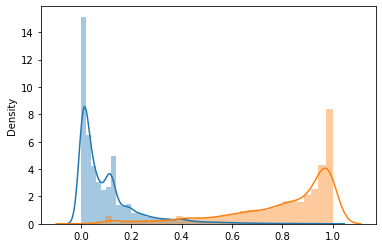

In [85]:
sns.distplot(pred_train[y_train==0], kde=True)
sns.distplot(pred_train[y_train==1], kde=True)

<AxesSubplot:ylabel='Density'>

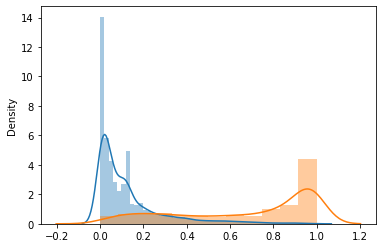

In [86]:
sns.distplot(pred_test[y_test==0], kde=True)
sns.distplot(pred_test[y_test==1], kde=True)

<AxesSubplot:ylabel='Density'>

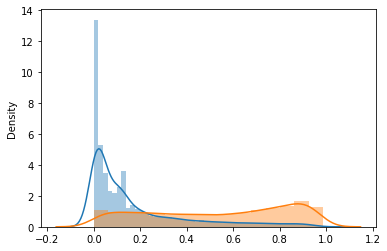

In [87]:
sns.distplot(pred_oot[y_oot==0], kde=True)
sns.distplot(pred_oot[y_oot==1], kde=True)

In [102]:
prediction_data_oot_total = data_oot.copy()
prediction_data_oot_total['pred'] = total_pred_oot

In [93]:
prediction_data_oot = data_oot_with_weight.copy()
prediction_data_oot['pred'] = pred_oot

<AxesSubplot:xlabel='pred', ylabel='Density'>

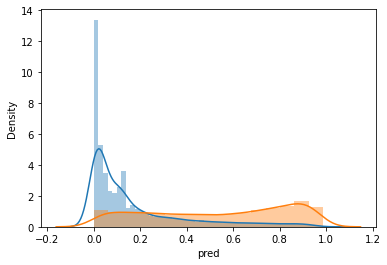

In [96]:
prediction_data_oot_grad = prediction_data_oot[prediction_data_oot.grad != 0]
sns.distplot(prediction_data_oot_grad[prediction_data_oot_grad[target] <= 1].pred, kde=True)
sns.distplot(prediction_data_oot_grad[prediction_data_oot_grad[target] >= 2].pred, kde=True)

#sns.distplot(prediction_data_oot_grad[prediction_data_oot_grad[target] == 2].pred, kde=True)
#sns.distplot(prediction_data_oot_grad[prediction_data_oot_grad[target] == 3].pred, kde=True)
#sns.distplot(prediction_data_oot_grad[prediction_data_oot_grad[target] == 4].pred, kde=True)


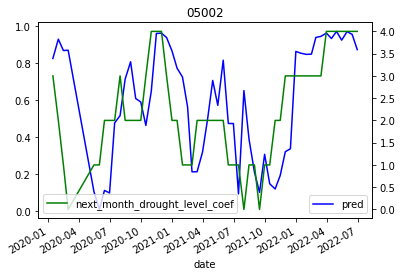

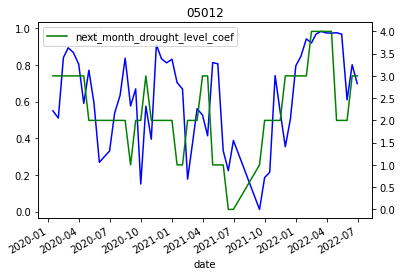

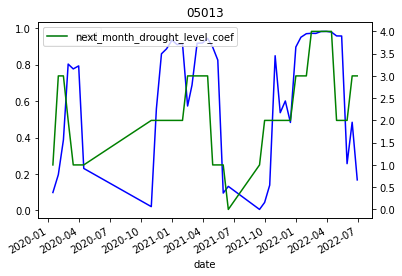

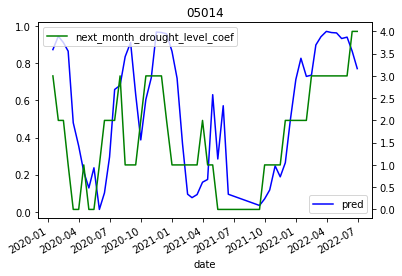

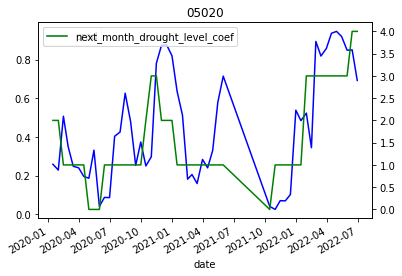

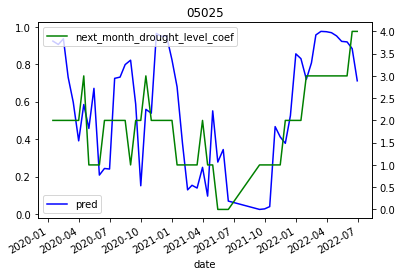

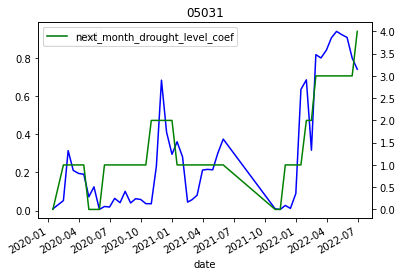

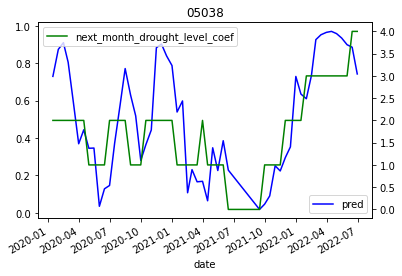

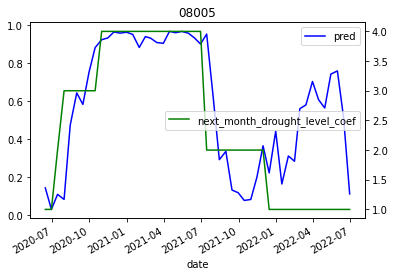

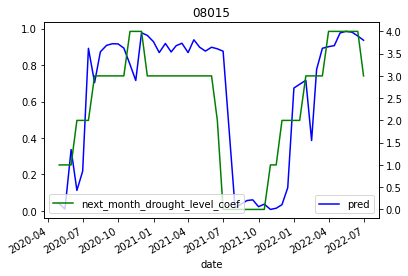

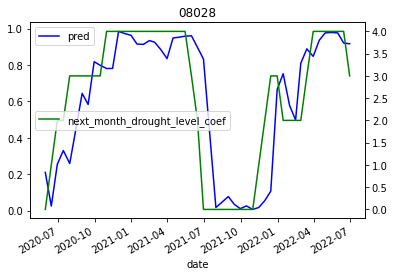

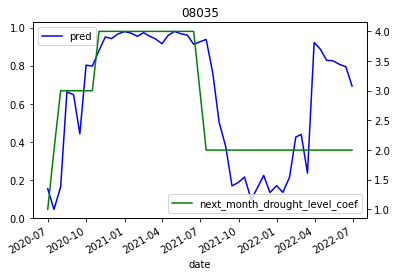

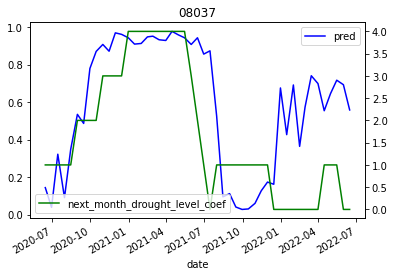

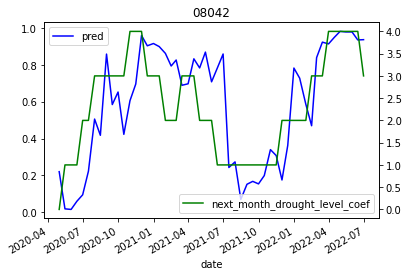

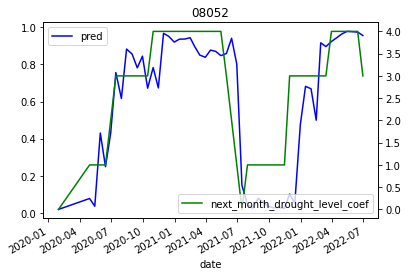

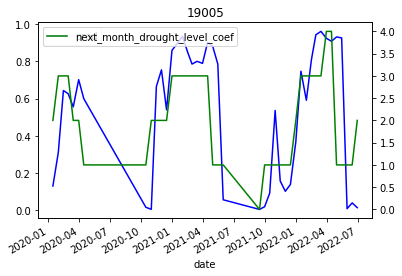

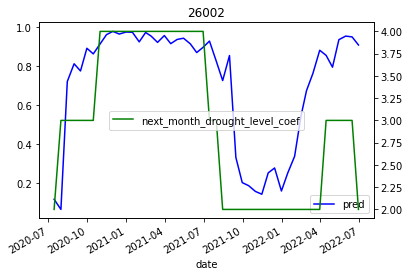

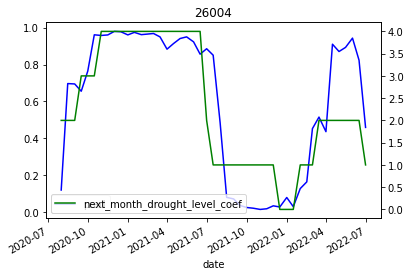

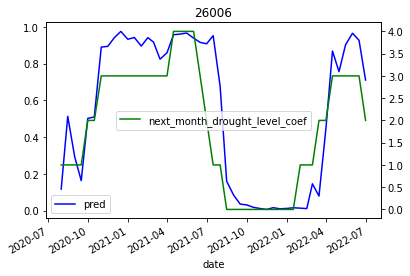

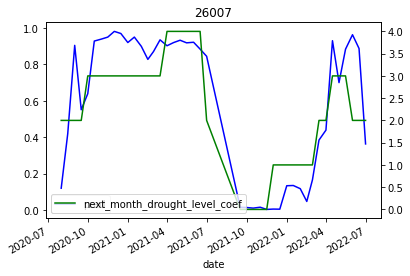

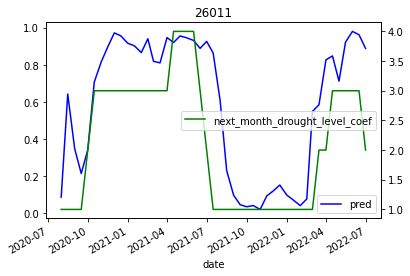

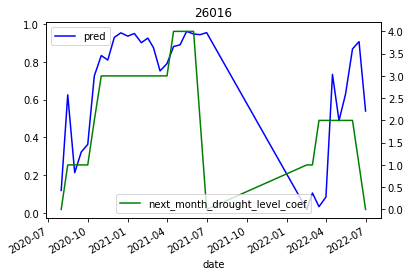

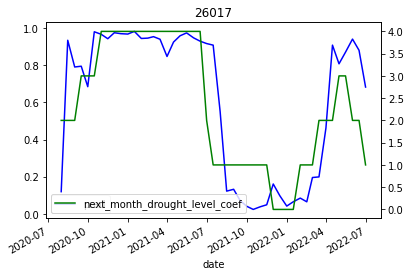

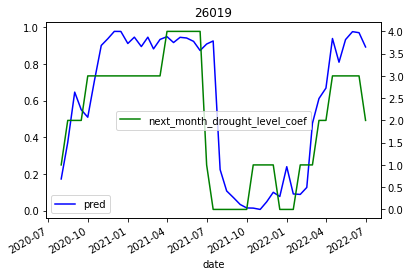

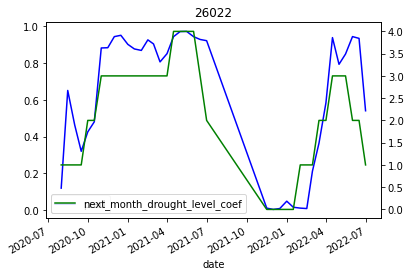

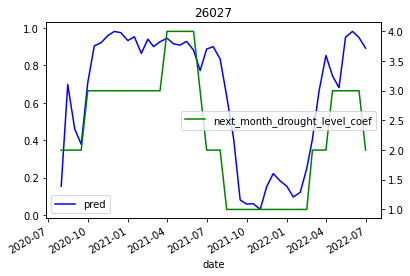

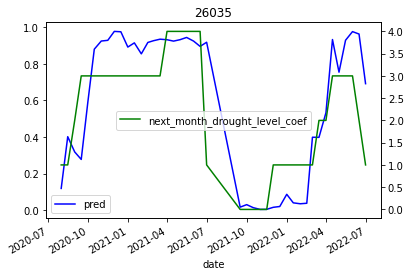

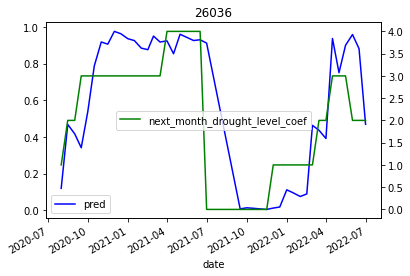

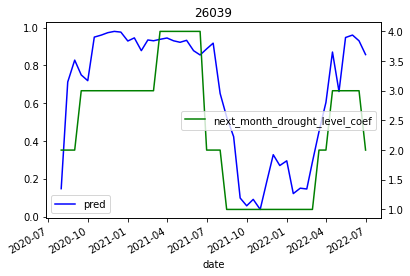

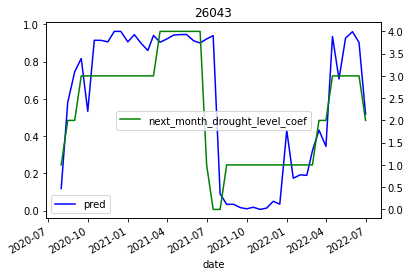

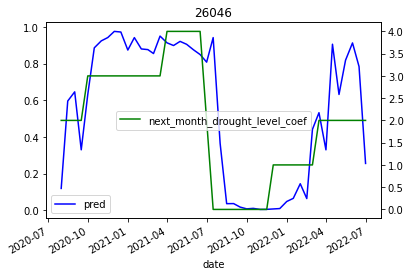

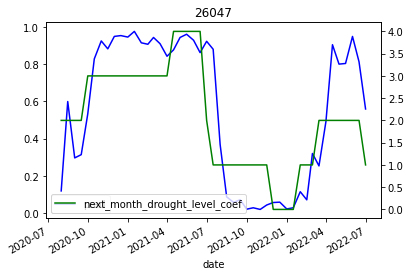

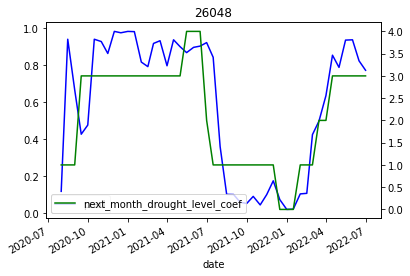

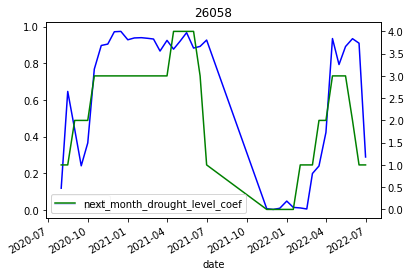

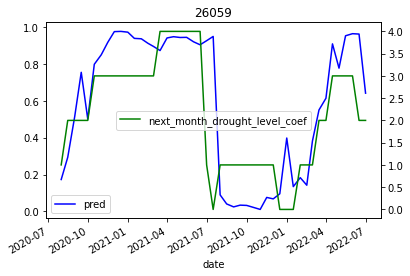

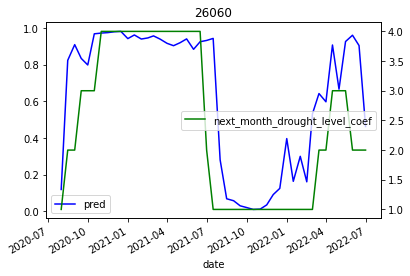

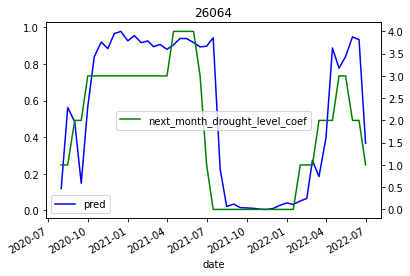

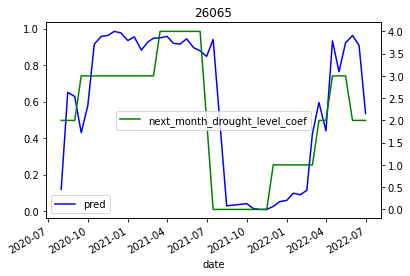

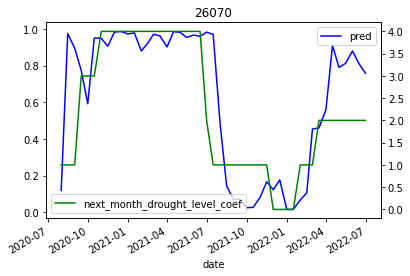

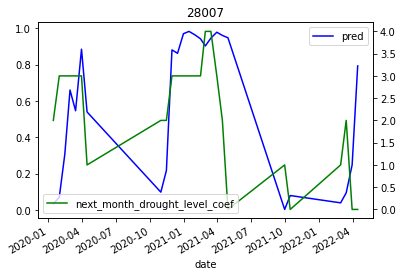

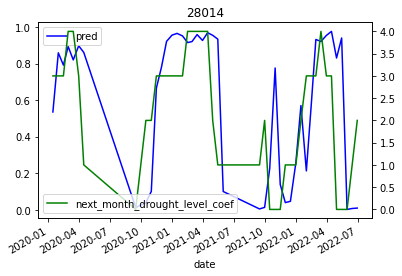

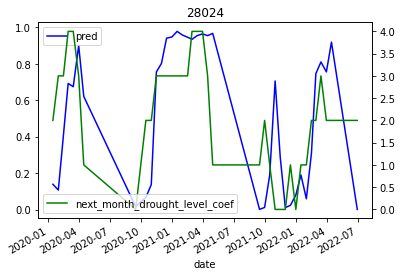

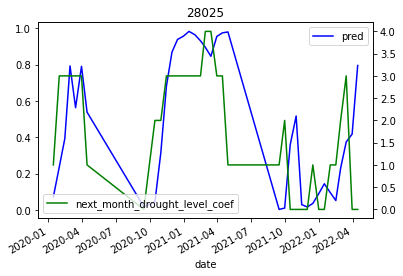

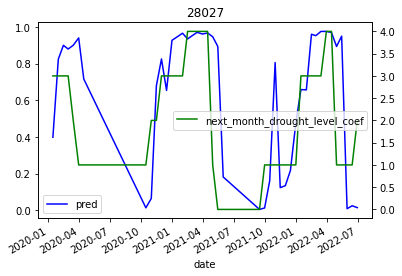

In [104]:
for mun in prediction_data_oot_grad[prediction_data_oot_grad[target] >= 4].CVE_CONCAT.unique():
    ax = prediction_data_oot_total[prediction_data_oot_total.CVE_CONCAT==mun].plot(x='date', y='pred', color='b')
    ax2 = ax.twinx()
    prediction_data_oot_total[prediction_data_oot_total.CVE_CONCAT==mun].plot(x='date', y='next_month_drought_level_coef', ax=ax2, color='g')
    #prediction_data_oot_total[prediction_data_oot_total.CVE_CONCAT==mun].plot(x='date', y='drought_level_coef', ax=ax2, color='r')
    plt.title(mun)
    plt.show()
    plt.close()

In [98]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


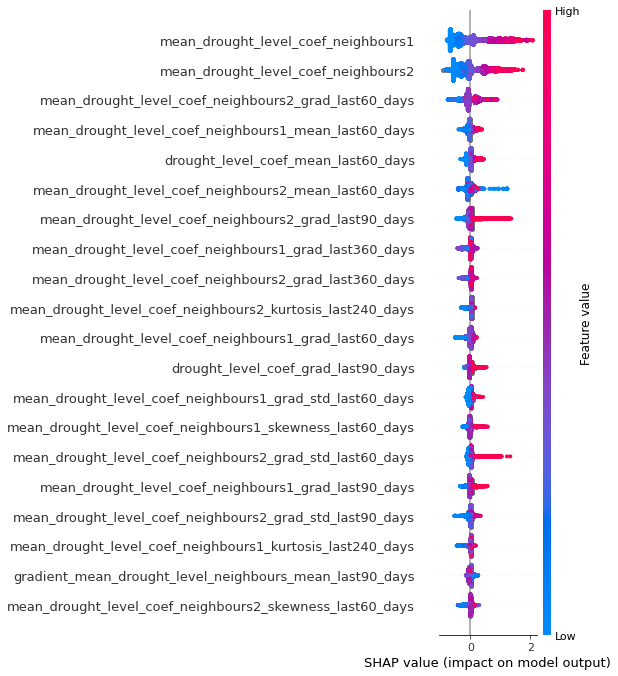

In [105]:
shap.summary_plot(shap_values, x_train)

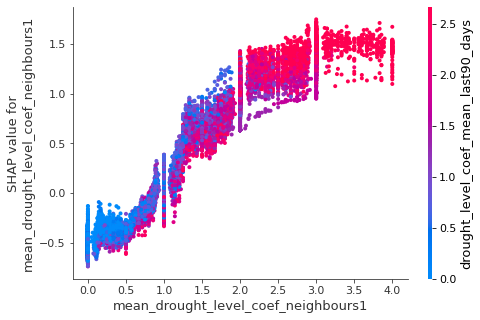

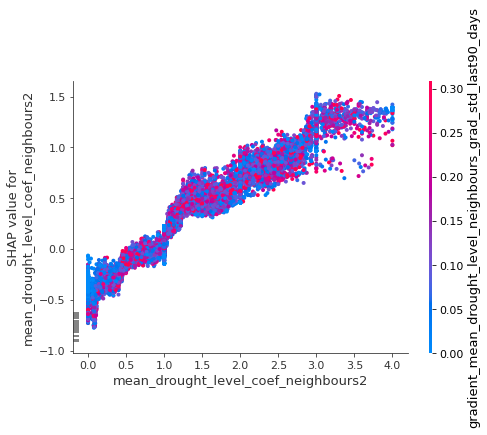

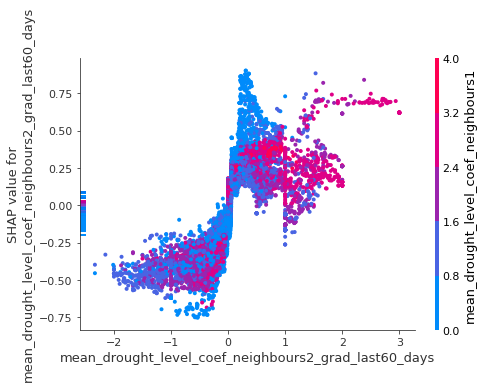

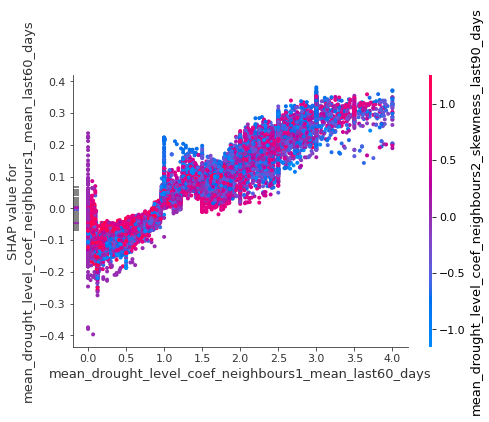

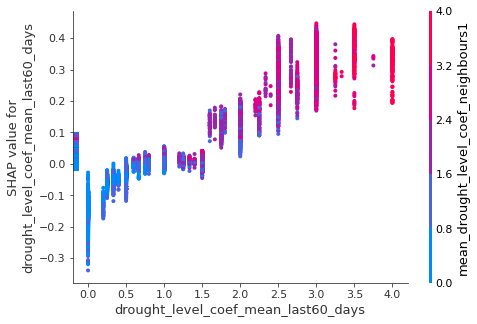

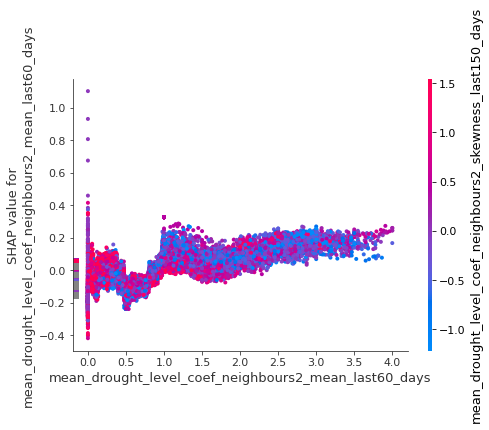

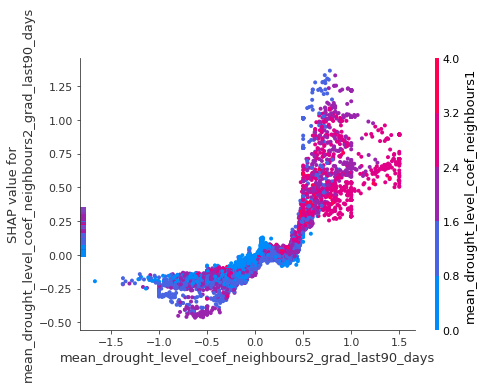

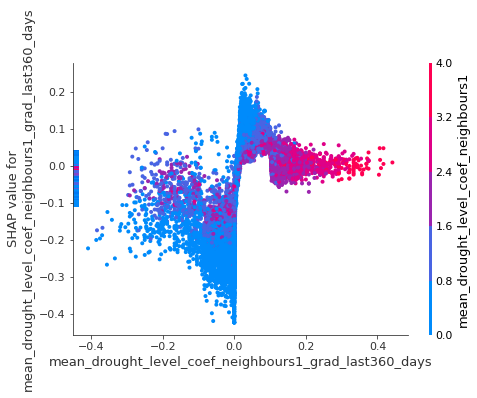

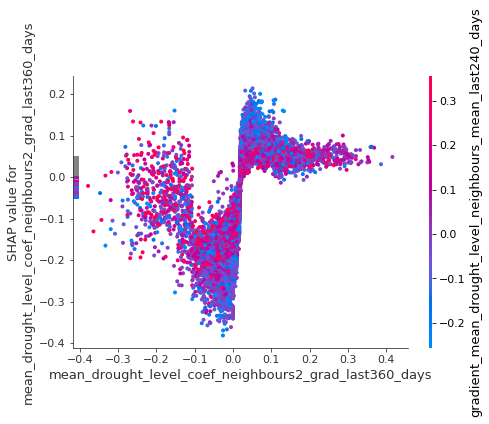

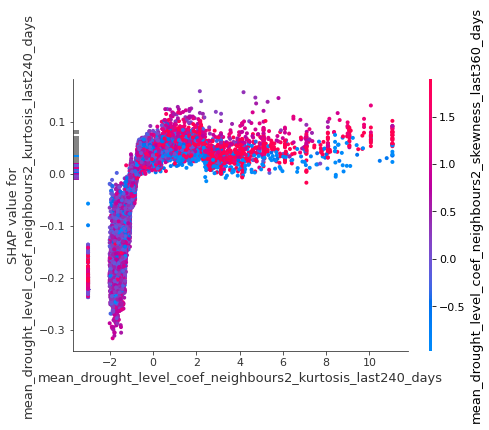

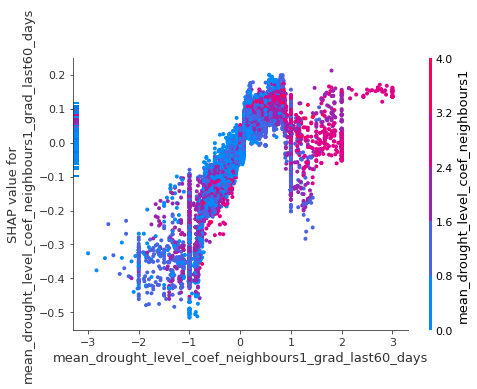

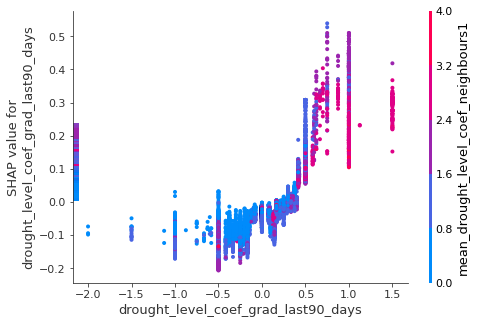

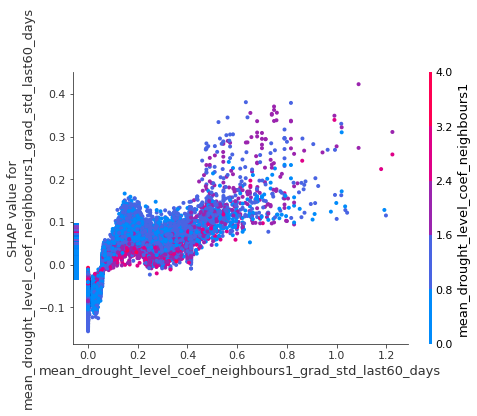

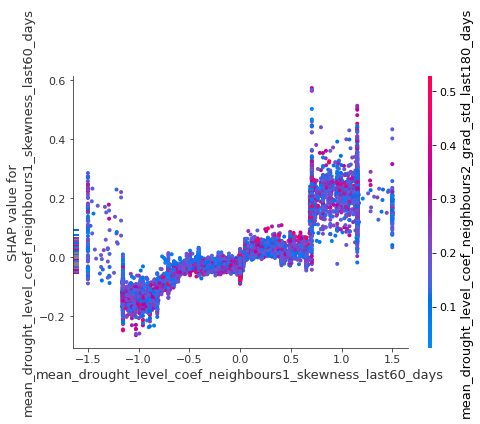

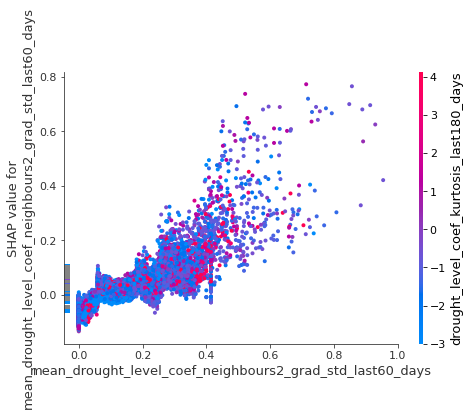

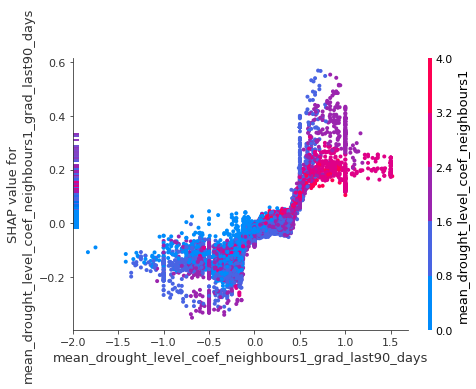

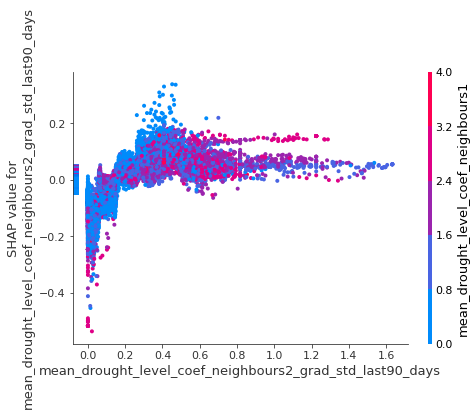

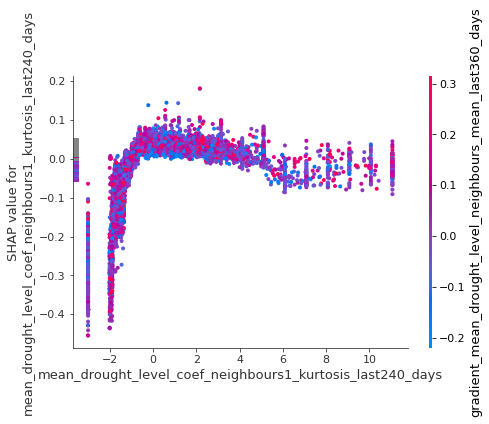

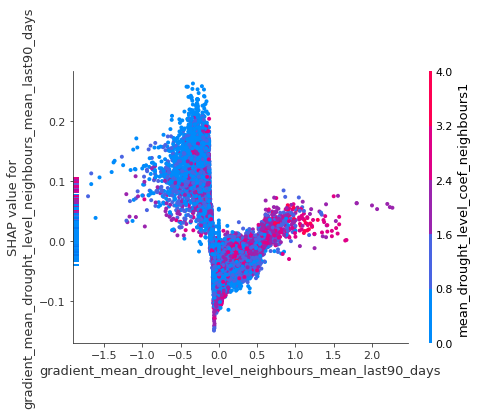

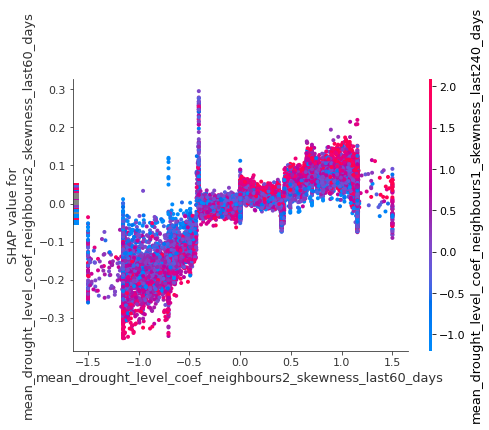

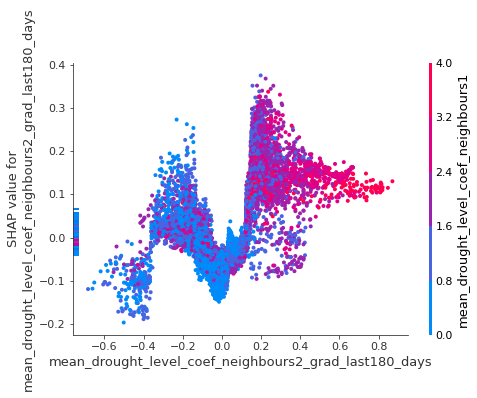

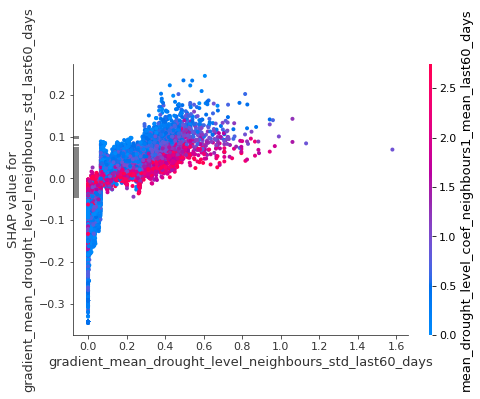

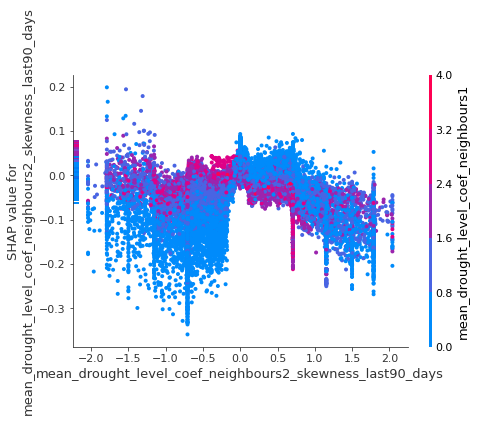

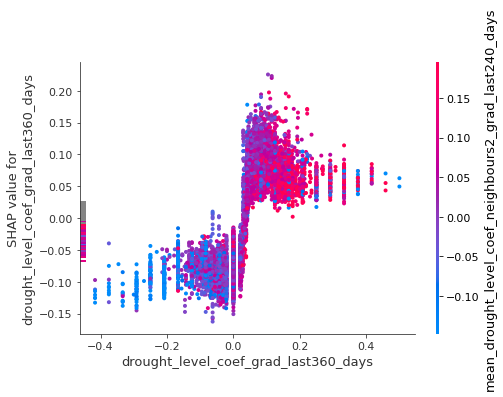

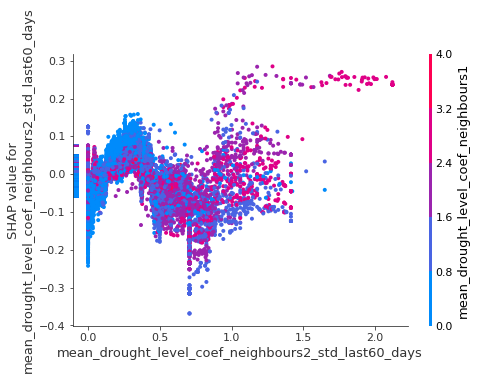

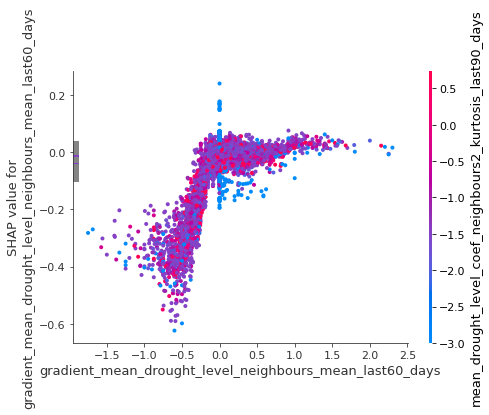

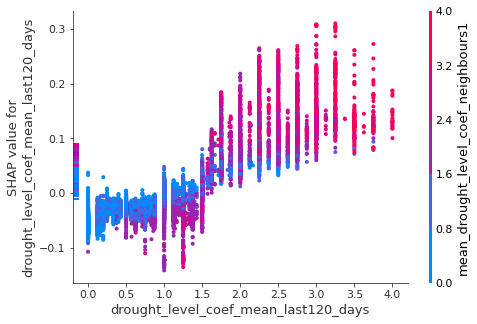

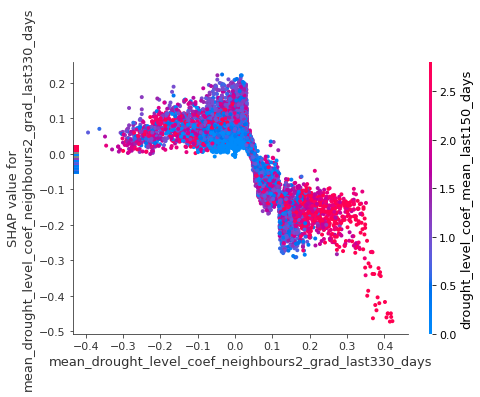

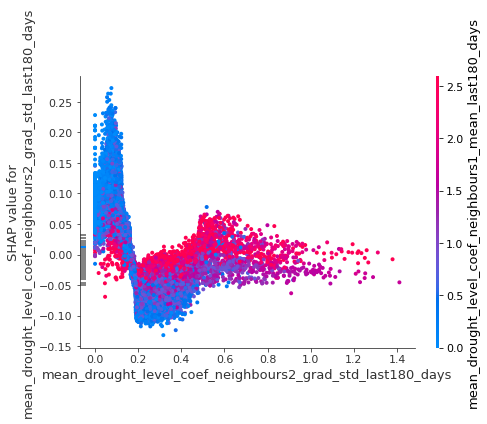

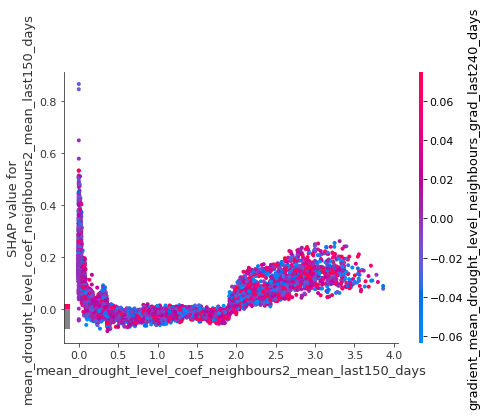

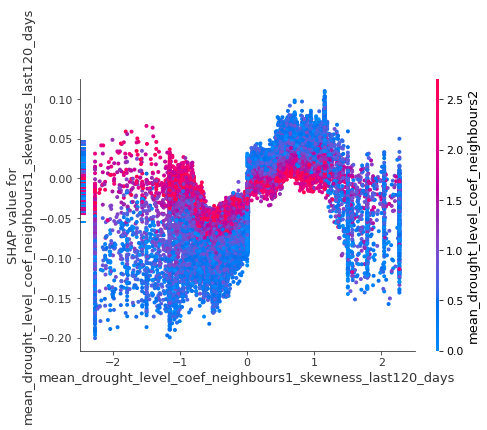

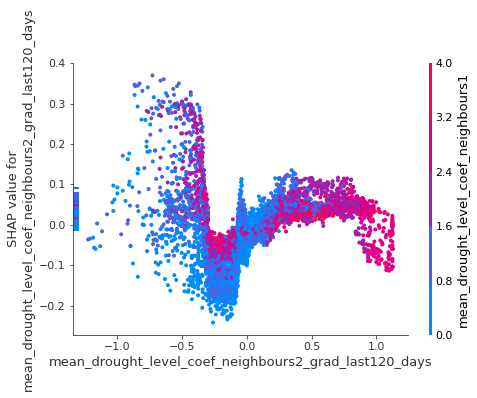

KeyboardInterrupt: 

In [106]:
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

for ind in top_inds:
    shap.dependence_plot(ind , shap_values, x_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


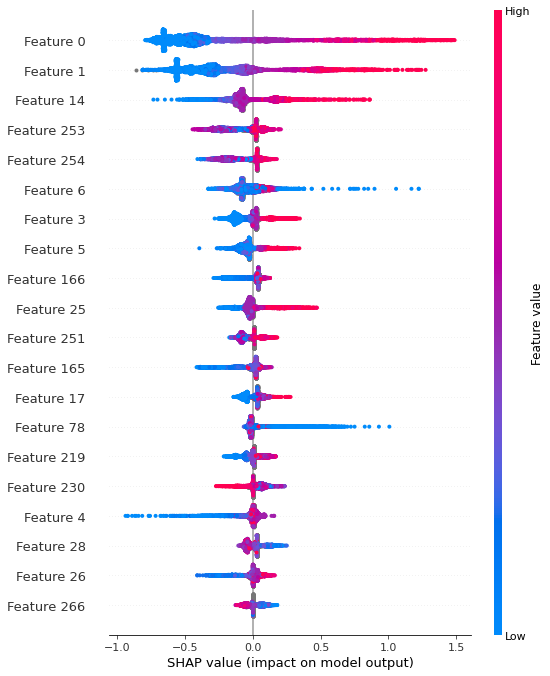

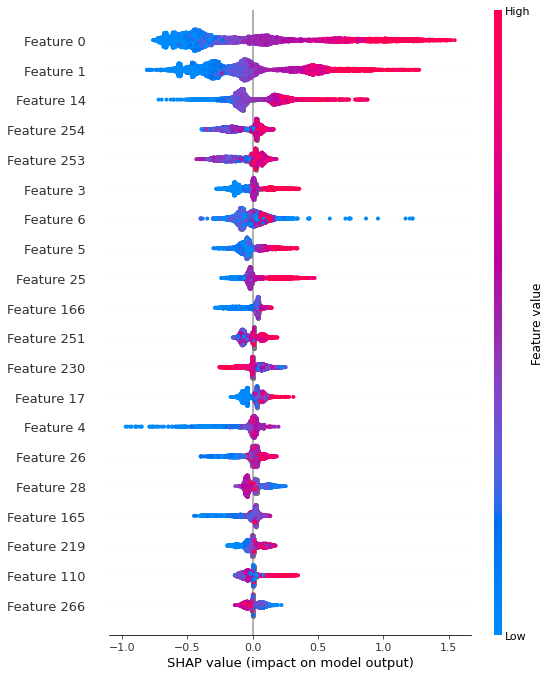

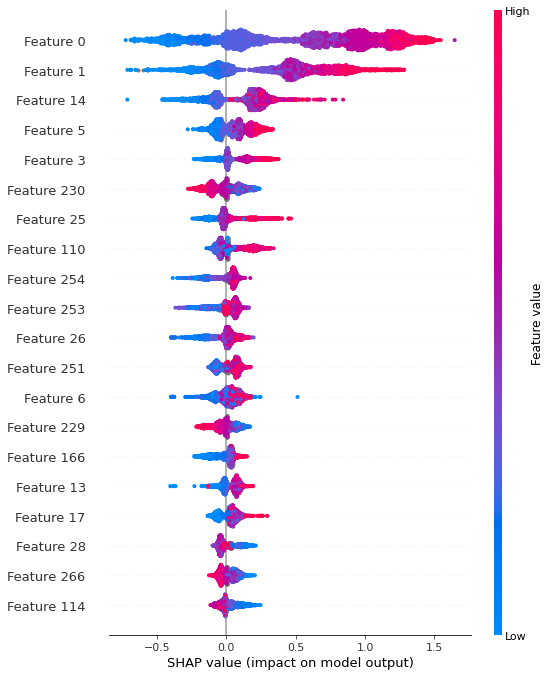

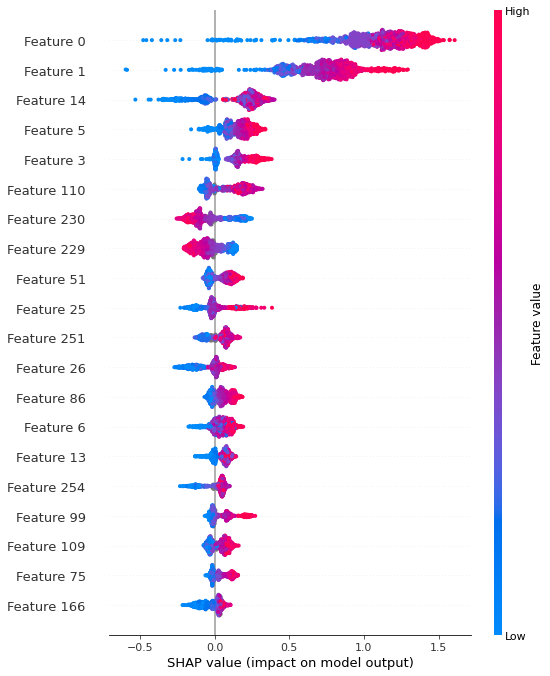

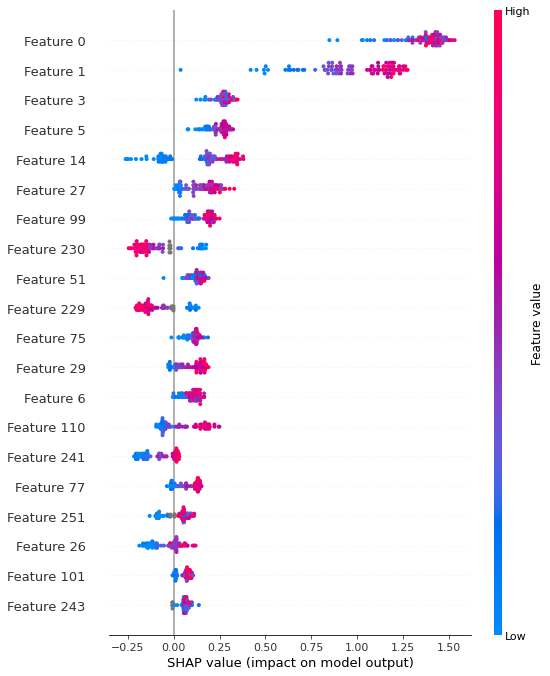

In [112]:
oot = {}
shap_values_oot = {}
for i in range(5):
    oot[f'{i}'] = prediction_data_oot_grad[prediction_data_oot_grad[target] == i]
    shap_values_oot[f'{i}'] = explainer.shap_values(oot[f'{i}'][feature_columns])
    shap.summary_plot(shap_values_oot[f'{i}'], np.array(oot[f'{i}'][feature_columns]))

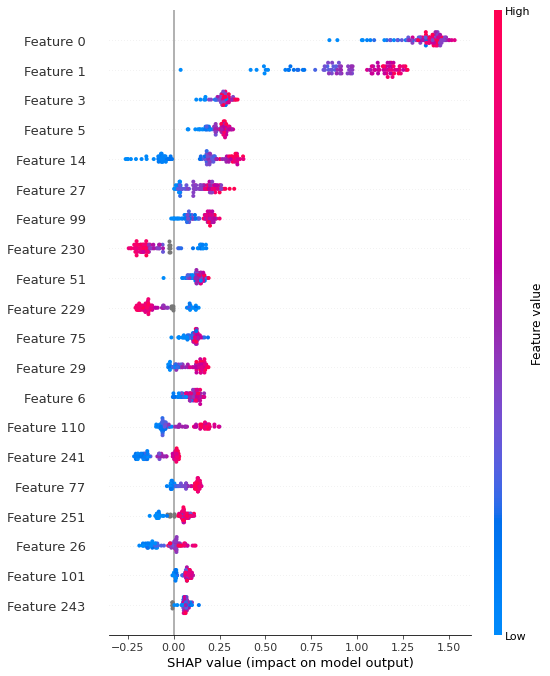

In [111]:
 shap.summary_plot(shap_values_oot[f'{i}'], np.array(oot[f'{i}'][feature_columns]))

In [113]:
prediction_data_oot_grad

CVE_CONCAT       date drought_level  drought_level_coef  \
54          01001 2020-10-31            D0                 0.0   
63          01001 2021-03-15            D1                 1.0   
64          01001 2021-03-31            D1                 1.0   
66          01001 2021-04-30            D2                 2.0   
67          01001 2021-05-15            D2                 2.0   
...           ...        ...           ...                 ...   
279133      32058 2022-01-31            D0                 0.0   
279134      32058 2022-02-15            D0                 0.0   
279138      32058 2022-04-15            D2                 2.0   
279139      32058 2022-04-30            D2                 2.0   
279140      32058 2022-05-15            D2                 2.0   

        mean_drought_level_coef_neighbours1  \
54                                 0.100000   
63                                 1.100000   
64                                 1.500000   
66                                 1.800000   
67                                 1.600000   
...                                     ...   
279133                             0.000000   
279134                             0.285714   
279138                             2.000000   
279139                             2.000000   
279140                             2.000000   

        mean_drought_level_coef_neighbours2  \
54                                 0.400000   
63                                 1.150000   
64                                 1.750000   
66                                 1.850000   
67                                 1.850000   
...                                     ...   
279133                             0.375000   
279134                             0.545455   
279138                             2.000000   
279139                             2.000000   
279140                             2.000000   

        gradient_mean_drought_level_neighbours future_date  \
54                                    -0.30000  2020-11-30   
63                                    -0.05000  2021-04-15   
64                                    -0.25000  2021-04-30   
66                                    -0.05000  2021-05-31   
67                                    -0.25000  2021-06-15   
...                                        ...         ...   
279133                                -0.37500  2022-02-28   
279134                                -0.25974  2022-03-15   
279138                                 0.00000  2022-05-15   
279139                                 0.00000  2022-05-31   
279140                                 0.00000  2022-06-15   

       unique_index_cve_date future_unique_index_cve_date  ...  \
54          01001_2020-10-31             01001_2020-11-30  ...   
63          01001_2021-03-15             01001_2021-04-15  ...   
64          01001_2021-03-31             01001_2021-04-30  ...   
66          01001_2021-04-30             01001_2021-05-31  ...   
67          01001_2021-05-15             01001_2021-06-15  ...   
...                      ...                          ...  ...   
279133      32058_2022-01-31             32058_2022-02-28  ...   
279134      32058_2022-02-15             32058_2022-03-15  ...   
279138      32058_2022-04-15             32058_2022-05-15  ...   
279139      32058_2022-04-30             32058_2022-05-31  ...   
279140      32058_2022-05-15             32058_2022-06-15  ...   

        mean_drought_level_coef_neighbours2_grad_std_last360_days  \
54                                                    NaN           
63                                               0.077616           
64                                               0.154230           
66                                               0.113389           
67                                               0.117568           
...                                                   ...           
279133                                           0.332350      